In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import shap
from sklearn.inspection import permutation_importance
import numpy as np
from scipy.stats import mode
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [ ]:
df_2017 = pd.read_csv("2017.csv")
df_2019 = pd.read_csv("2019.csv")

In [ ]:
models_to_test = ["random_forest", "xgboost", "logistic_regression", "mlp", "knn"]

In [ ]:
def get_model(model_type):
    if model_type == "random_forest":
        return RandomForestClassifier(random_state=42)
    elif model_type == "logistic_regression":
        return LogisticRegression(max_iter=1000, random_state=42)
    elif model_type == "xgboost":
        return XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    elif model_type == "mlp":
        return MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
    elif model_type == "knn":
        return KNeighborsClassifier(n_neighbors=5)
    else:
        raise ValueError(f"Nieobsługiwany model: {model_type}")

def show_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bening", "DDoS"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    plt.grid(False)
    plt.show()

def run_full_experiment(df_train_full, df_test, feature_cols, label_train='2019', label_test='2017', model_type='random_forest'):
    df_train, df_val = train_test_split(df_train_full, test_size=0.1, random_state=42, stratify=df_train_full['Label'])

    X_train = df_train[feature_cols]
    y_train = df_train['Label']
    X_val = df_val[feature_cols]
    y_val = df_val['Label']
    X_test = df_test[feature_cols]
    y_test = df_test['Label']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    model = get_model(model_type)

    print(f"\n=== Model: {model_type.upper()} | Trening na {label_train} (90%), walidacja na {label_train} (10%) ===")
    model.fit(X_train_scaled, y_train)
    y_pred_val = model.predict(X_val_scaled)
    print("Wyniki walidacji:")
    print(classification_report(y_val, y_pred_val))
    show_confusion_matrix(y_val, y_pred_val, title=model_type)

    print(f"\n=== Test na zbiorze {label_test} ===")
    y_pred_test = model.predict(X_test_scaled)
    print("Wyniki testu cross-dataset:")
    print(classification_report(y_test, y_pred_test))
    show_confusion_matrix(y_test, y_pred_test, title=f"Test {model_type} na zbiorze {label_test}")

    return model

In [ ]:
def train_model(df, feature_cols):
    X = df[feature_cols]
    y = df["Label"]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_scaled, y)
    return model, scaler


def compute_shap(model, X_scaled, feature_names):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_scaled)
    shap_df = pd.DataFrame(np.abs(shap_values.values), columns=feature_names)
    mean_shap = shap_df.mean().sort_values(ascending=False)
    return mean_shap


def compute_permutation(model, X_scaled, y, feature_names):
    result = permutation_importance(model, X_scaled, y, n_repeats=10, random_state=42, n_jobs=-1)
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    }).sort_values(by='importance_mean', ascending=False)
    return importance_df


def plot_shap_comparison(shap1, shap2, title1, title2):
    df = pd.DataFrame({title1: shap1, title2: shap2})
    df = df.fillna(0)
    df.plot(kind='barh', figsize=(10, 12), alpha=0.7)
    plt.xlabel("Średnia wartość SHAP")
    plt.title(f"Porównanie SHAP: {title1} vs {title2}")
    plt.tight_layout()
    plt.show()

def compare_stable_features(shap_train, shap_test, perm_train, perm_test,
                            shap_threshold=0.2, perm_threshold=0.01):
    # SHAP: oblicz różnicę bezwzględną między średnimi (bardziej stabilna miara niż zakres)
    shap_df = pd.concat([shap_train, shap_test], axis=1, keys=['SHAP_train', 'SHAP_test']).fillna(0)
    shap_df['shap_diff'] = (shap_df['SHAP_train'] - shap_df['SHAP_test']).abs().round(4)
    shap_stable = shap_df[shap_df['shap_diff'] <= shap_threshold]

    # Permutation: zakres między train i test, ignorujemy cechy ze średnią < 0
    perm_merged = pd.merge(
        perm_train[['feature', 'importance_mean']],
        perm_test[['feature', 'importance_mean']],
        on='feature', suffixes=('_train', '_test')
    )

    # Oblicz różnicę i przefiltruj cechy o sensownym, dodatnim wpływie
    perm_merged['perm_range'] = (perm_merged[['importance_mean_train', 'importance_mean_test']]
                                 .max(axis=1) - perm_merged[['importance_mean_train', 'importance_mean_test']]
                                 .min(axis=1)).round(4)
    
    # Tylko cechy o dodatniej średniej permutacji i niskim zakresie
    perm_filtered = perm_merged[
        (perm_merged['importance_mean_train'] > 0) &
        (perm_merged['importance_mean_test'] > 0) &
        (perm_merged['perm_range'] <= perm_threshold)
    ]

    # Wspólne cechy z SHAP i Permutation
    stable_features = sorted(set(shap_stable.index).intersection(set(perm_filtered['feature'])))

    print(f"\n✅ Wybrano {len(stable_features)} stabilnych cech wspólnych SHAP + Permutation (|diff| ≤ {shap_threshold}, perm range ≤ {perm_threshold})\n")
    for feat in stable_features:
        shap_diff = shap_df.loc[feat]['shap_diff']
        perm_row = perm_filtered[perm_filtered['feature'] == feat].iloc[0]
        perm_range = perm_row['perm_range']
        print(f" - {feat}: SHAP diff = {shap_diff:.4f}, Perm range = {perm_range:.4f}")
    
    return stable_features

def plot_permutation_comparison(perm1, perm2, title1, title2):
    df1 = perm1.set_index('feature')['importance_mean']
    df2 = perm2.set_index('feature')['importance_mean']
    df = pd.concat([df1, df2], axis=1, keys=[title1, title2]).fillna(0)
    df.plot(kind='barh', figsize=(10, 12), alpha=0.7)
    plt.xlabel("Średnia Permutation Importance")
    plt.title(f"Porównanie Permutation Importance: {title1} vs {title2}")
    plt.tight_layout()
    plt.show()
    
def run_experiment(df_train, df_test, feature_cols, label="Label"):
    # Trenuj na train
    model, scaler = train_model(df_train, feature_cols)
    X_train = scaler.transform(df_train[feature_cols])
    y_train = df_train[label]

    X_test = scaler.transform(df_test[feature_cols])
    y_test = df_test[label]

    # Oblicz SHAP
    shap_train = compute_shap(model, X_train, feature_cols)
    shap_test = compute_shap(model, X_test, feature_cols)

    # Oblicz Permutation Importance
    perm_train = compute_permutation(model, X_train, y_train, feature_cols)
    perm_test = compute_permutation(model, X_test, y_test, feature_cols)

    # Porównaj SHAP
    plot_shap_comparison(shap_train, shap_test, "SHAP_train", "SHAP_test")

    # Porównaj Permutation Importance
    plot_permutation_comparison(perm_train, perm_test, "Perm_train", "Perm_test")

    # Analiza stabilności na podstawie SHAP + Permutation
    stable_features = compare_stable_features(shap_train, shap_test, perm_train, perm_test)

    return shap_train, shap_test, perm_train, perm_test, stable_features


/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:41:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


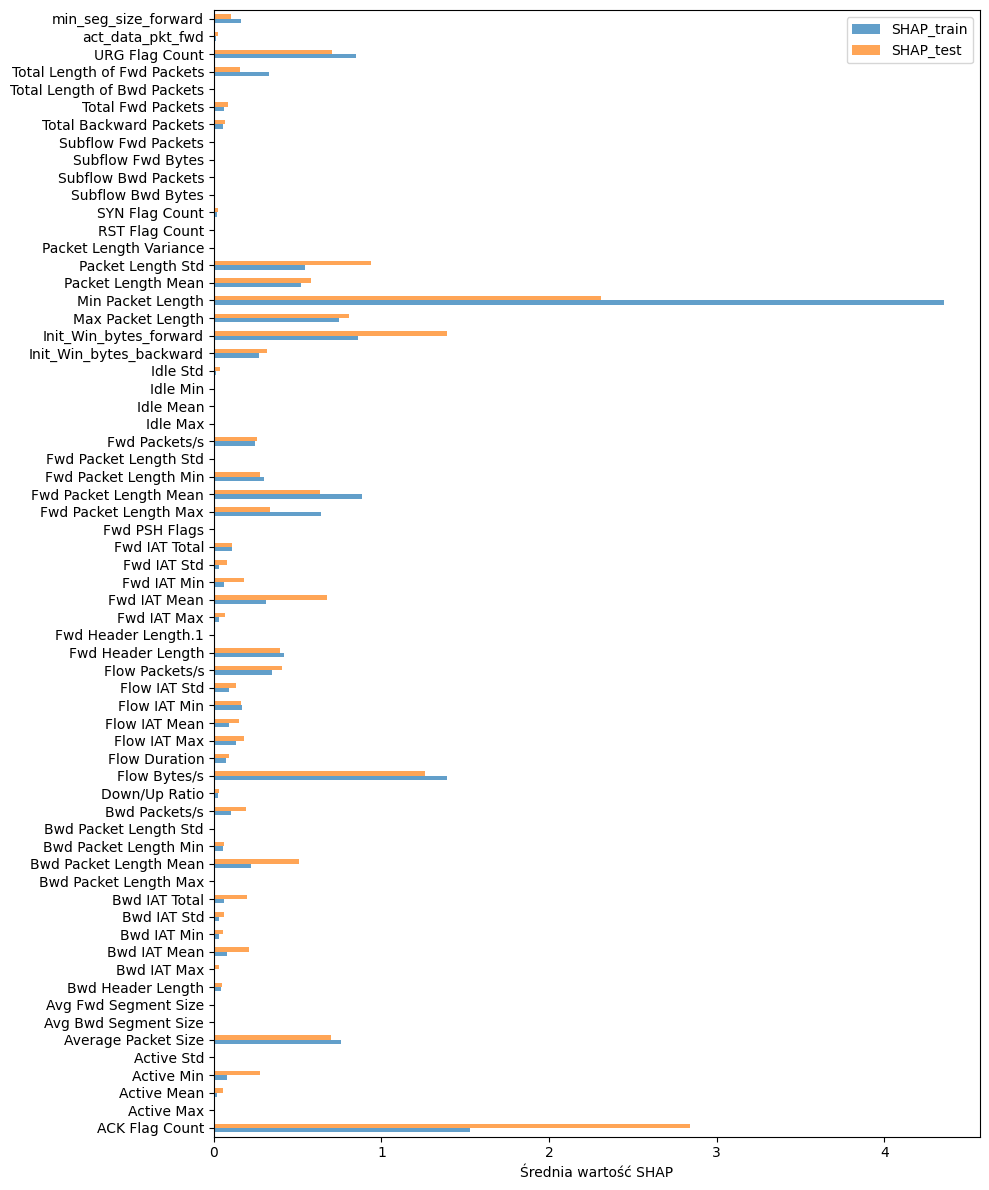

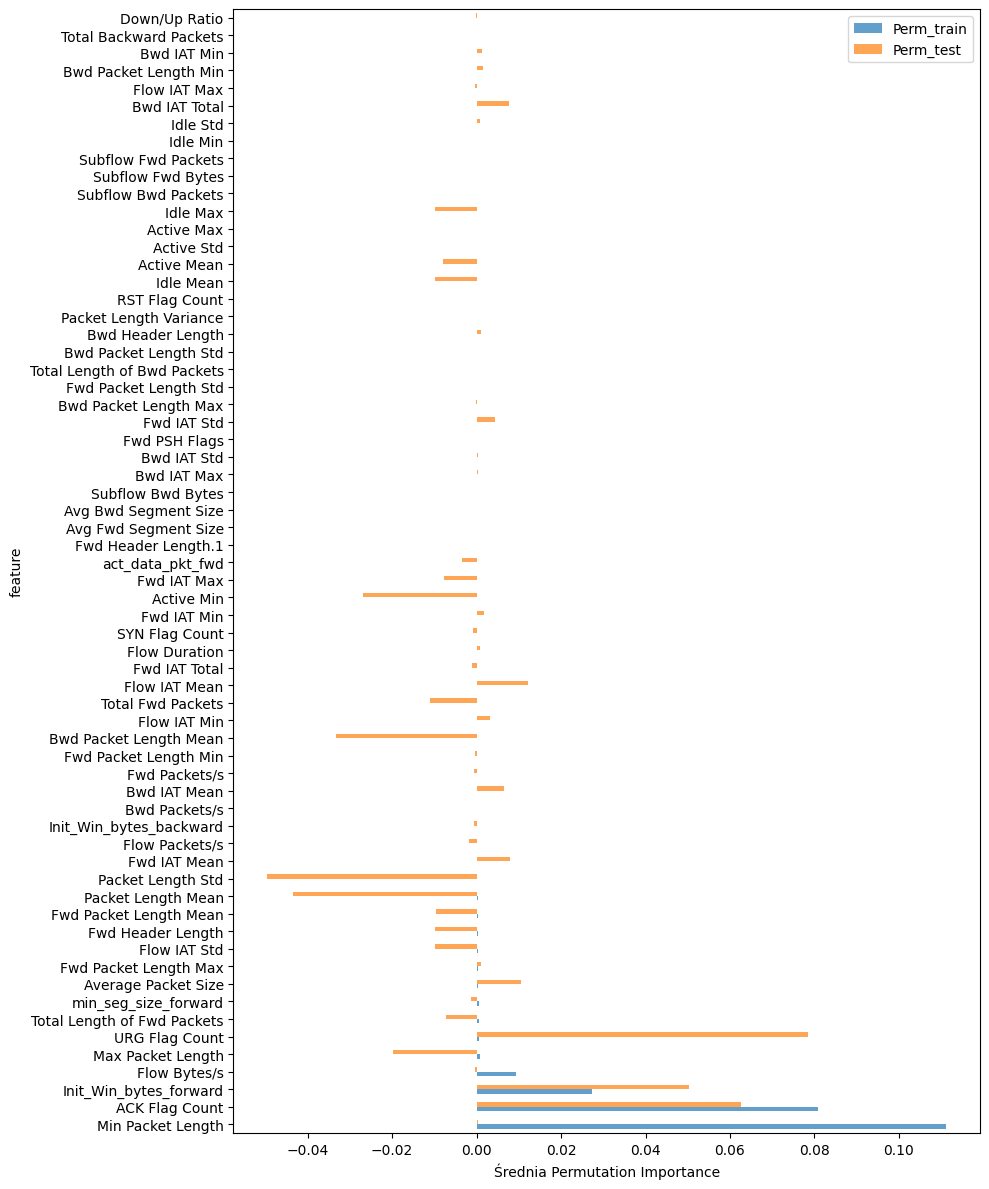


✅ Wybrano 47 stabilnych cech wspólnych SHAP + Permutation (≤ 0.2 / 0.01)

 - Active Max: SHAP range = 0.0000, Perm range = 0.0000
 - Active Mean: SHAP range = 0.0404, Perm range = 0.0079
 - Active Std: SHAP range = 0.0000, Perm range = 0.0000
 - Avg Bwd Segment Size: SHAP range = 0.0000, Perm range = 0.0000
 - Avg Fwd Segment Size: SHAP range = 0.0000, Perm range = 0.0000
 - Bwd Header Length: SHAP range = 0.0055, Perm range = 0.0012
 - Bwd IAT Max: SHAP range = 0.0255, Perm range = 0.0003
 - Bwd IAT Mean: SHAP range = 0.1273, Perm range = 0.0063
 - Bwd IAT Min: SHAP range = 0.0287, Perm range = 0.0012
 - Bwd IAT Std: SHAP range = 0.0275, Perm range = 0.0003
 - Bwd IAT Total: SHAP range = 0.1345, Perm range = 0.0078
 - Bwd Packet Length Max: SHAP range = 0.0004, Perm range = 0.0002
 - Bwd Packet Length Min: SHAP range = 0.0036, Perm range = 0.0015
 - Bwd Packet Length Std: SHAP range = 0.0000, Perm range = 0.0000
 - Bwd Packets/s: SHAP range = 0.0903, Perm range = 0.0000
 - Down/Up Ra

/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:45:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


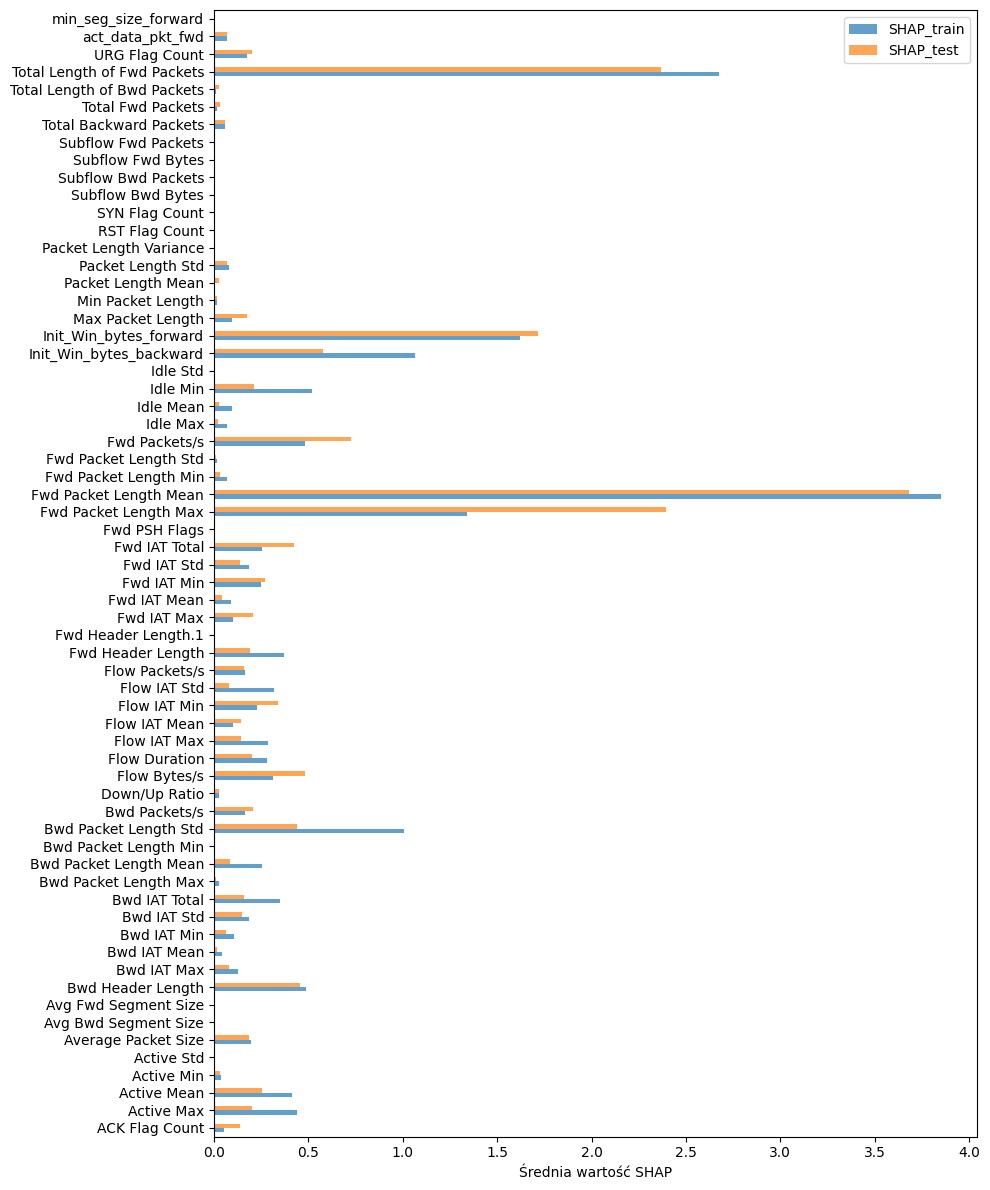

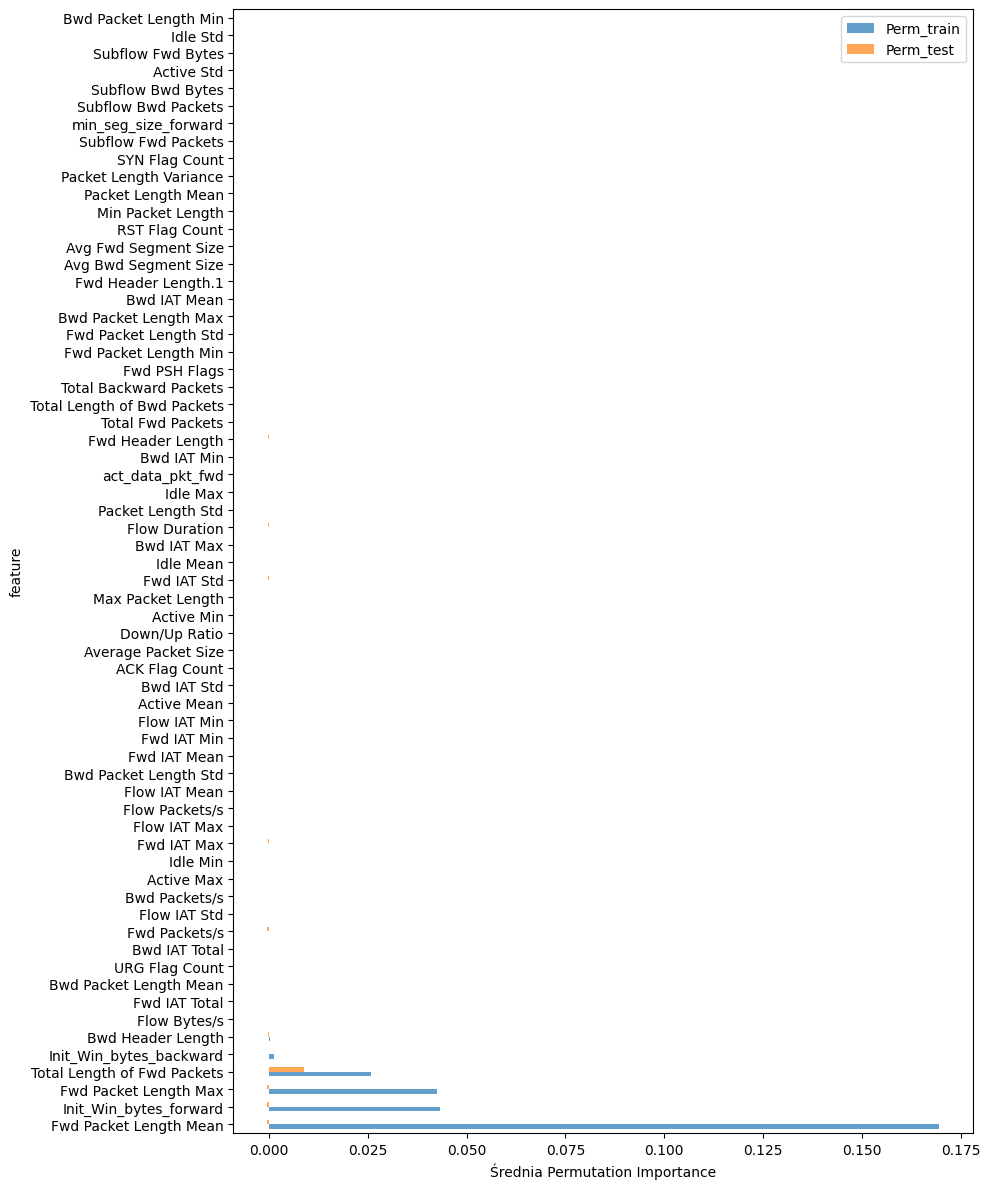


✅ Wybrano 54 stabilnych cech wspólnych SHAP + Permutation (≤ 0.2 / 0.01)

 - ACK Flag Count: SHAP range = 0.0830, Perm range = 0.0000
 - Active Mean: SHAP range = 0.1596, Perm range = 0.0000
 - Active Min: SHAP range = 0.0049, Perm range = 0.0000
 - Active Std: SHAP range = 0.0000, Perm range = 0.0000
 - Average Packet Size: SHAP range = 0.0151, Perm range = 0.0000
 - Avg Bwd Segment Size: SHAP range = 0.0000, Perm range = 0.0000
 - Avg Fwd Segment Size: SHAP range = 0.0000, Perm range = 0.0000
 - Bwd Header Length: SHAP range = 0.0367, Perm range = 0.0004
 - Bwd IAT Max: SHAP range = 0.0462, Perm range = 0.0000
 - Bwd IAT Mean: SHAP range = 0.0221, Perm range = 0.0000
 - Bwd IAT Min: SHAP range = 0.0433, Perm range = 0.0000
 - Bwd IAT Std: SHAP range = 0.0394, Perm range = 0.0000
 - Bwd IAT Total: SHAP range = 0.1943, Perm range = 0.0000
 - Bwd Packet Length Max: SHAP range = 0.0130, Perm range = 0.0000
 - Bwd Packet Length Mean: SHAP range = 0.1707, Perm range = 0.0000
 - Bwd Packet

In [ ]:
shap_2019_2019, shap_2019_2017, perm_2019_2019, perm_2019_2017, stable_2019 = run_experiment(df_2019, df_2017, feature_cols)
shap_2017_2017, shap_2017_2019, perm_2017_2017, perm_2017_2019, stable_2017 = run_experiment(df_2017, df_2019, feature_cols)
common_stable_features = sorted(set(stable_2017).intersection(stable_2019))
print("\nWspólne stabilne cechy do trenowania końcowego modelu:")
print(common_stable_features)

In [ ]:
print(stable_2017 + stable_2019)
stable = list(set(stable_2019 + stable_2017))
print(stable)

['Average Packet Size', 'Bwd IAT Std', 'Bwd IAT Total', 'Flow IAT Max', 'Fwd IAT Total', 'Idle Max', 'URG Flag Count', 'Bwd IAT Mean', 'Bwd Packets/s', 'Flow Duration', 'Flow IAT Min', 'Fwd IAT Min']
['URG Flag Count', 'Flow IAT Max', 'Fwd IAT Min', 'Idle Max', 'Bwd IAT Mean', 'Bwd IAT Total', 'Fwd IAT Total', 'Flow IAT Min', 'Bwd IAT Std', 'Flow Duration', 'Bwd Packets/s', 'Average Packet Size']



================= TEST: RANDOM_FOREST (2019 → 2017) =================

=== Model: RANDOM_FOREST | Trening na CICDDoS2019 (90%), walidacja na CICDDoS2019 (10%) ===
Wyniki walidacji:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2802
           1       0.99      1.00      0.99      3000

    accuracy                           0.99      5802
   macro avg       0.99      0.99      0.99      5802
weighted avg       0.99      0.99      0.99      5802



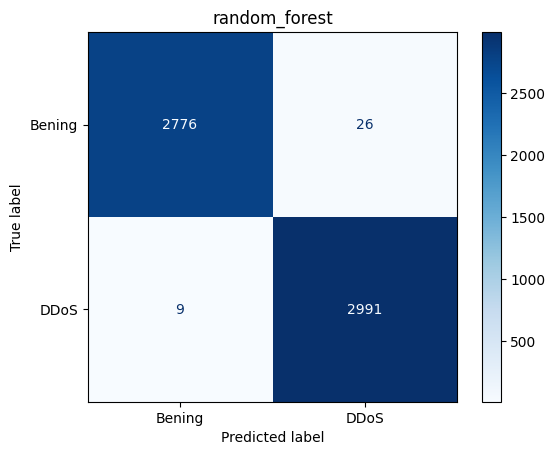


=== Test na zbiorze CICIDS2017 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.44      0.96      0.61     97718
           1       0.72      0.07      0.13    128027

    accuracy                           0.46    225745
   macro avg       0.58      0.52      0.37    225745
weighted avg       0.60      0.46      0.33    225745



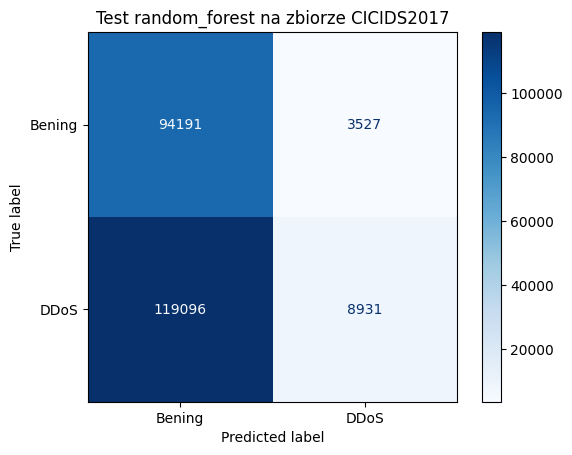


=== Analiza błędów: CICDDoS2019 → CICIDS2017 (random_forest) ===

🔍 False Positives (FP):
                count          mean           std  min   25%   50%    75%  \
Fwd IAT Total  3527.0  1.170866e+06  1.153196e+07  0.0   2.0  61.0  137.0   
Flow Duration  3527.0  1.170710e+06  1.153018e+07 -1.0  43.0  82.0  140.0   
Flow IAT Max   3527.0  2.027075e+05  2.036507e+06 -1.0  39.0  76.0  134.0   
Idle Max       3527.0  2.023816e+05  2.036498e+06  0.0   0.0   0.0    0.0   
Bwd Packets/s  3527.0  1.549798e+04  8.515875e+04  0.0   0.0   0.0    0.0   

                       max  
Fwd IAT Total  120000000.0  
Flow Duration  119999937.0  
Flow IAT Max    28300000.0  
Idle Max        28300000.0  
Bwd Packets/s    1000000.0  

🔍 False Negatives (FN):
                  count          mean           std  min        25%  \
Flow Duration  119096.0  1.789082e+07  3.195116e+07  2.0  544601.25   
Fwd IAT Total  119096.0  1.741902e+07  3.187271e+07  0.0    2251.00   
Flow IAT Max   119096.0  1.668935e

/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:12:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Wyniki walidacji:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2802
           1       0.99      1.00      1.00      3000

    accuracy                           0.99      5802
   macro avg       0.99      0.99      0.99      5802
weighted avg       0.99      0.99      0.99      5802



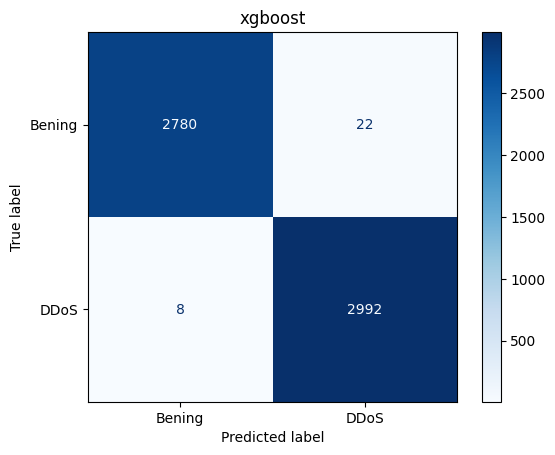


=== Test na zbiorze CICIDS2017 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.42      0.94      0.58     97718
           1       0.35      0.03      0.05    128027

    accuracy                           0.42    225745
   macro avg       0.39      0.48      0.32    225745
weighted avg       0.38      0.42      0.28    225745



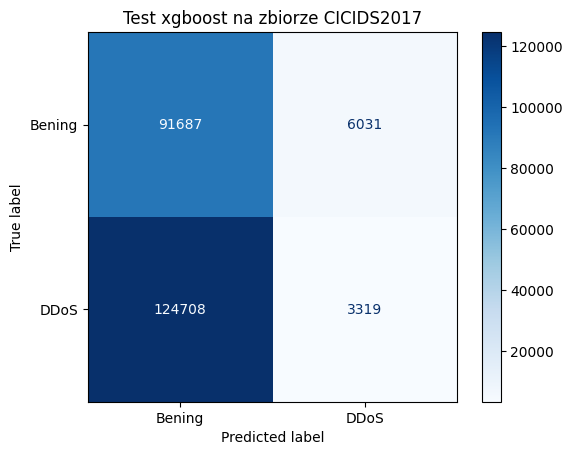


=== Analiza błędów: CICDDoS2019 → CICIDS2017 (xgboost) ===

🔍 False Positives (FP):
                count           mean           std  min   25%    50%  \
Flow Duration  6031.0  681048.258000  8.739717e+06 -1.0  64.0  146.0   
Fwd IAT Total  6031.0  676264.502902  8.739941e+06  0.0   3.0   56.0   
Flow IAT Max   6031.0  129622.958713  1.560385e+06 -1.0  59.0  108.0   
Idle Max       6031.0  116199.635218  1.551626e+06  0.0   0.0    0.0   
Bwd Packets/s  6031.0   14903.561305  7.298507e+04  0.0   0.0    0.0   

                       75%          max  
Flow Duration    205.00000  119999937.0  
Fwd IAT Total    195.00000  120000000.0  
Flow IAT Max     187.00000   28300000.0  
Idle Max           0.00000   28300000.0  
Bwd Packets/s  12195.12195    1000000.0  

🔍 False Negatives (FN):
                  count          mean           std    min        25%  \
Flow Duration  124708.0  1.727936e+07  3.134779e+07  134.0  598762.50   
Fwd IAT Total  124708.0  1.682878e+07  3.126277e+07    0.0 

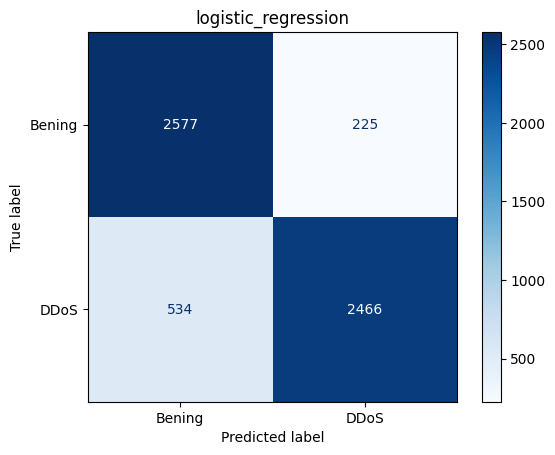


=== Test na zbiorze CICIDS2017 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.64      0.83      0.72     97718
           1       0.83      0.64      0.72    128027

    accuracy                           0.72    225745
   macro avg       0.73      0.73      0.72    225745
weighted avg       0.75      0.72      0.72    225745



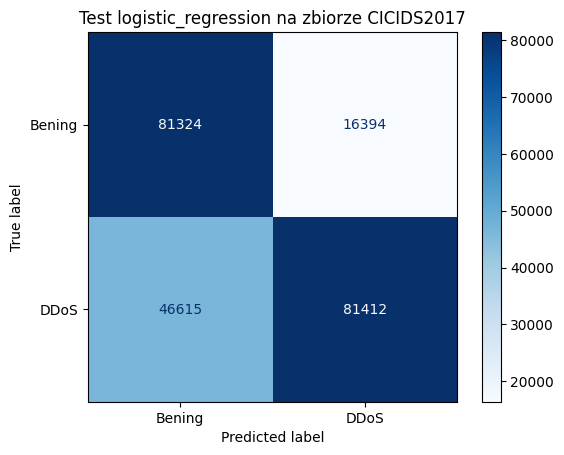


=== Analiza błędów: CICDDoS2019 → CICIDS2017 (logistic_regression) ===

🔍 False Positives (FP):
                 count          mean           std  min       25%       50%  \
Flow Duration  16394.0  1.218966e+07  2.998014e+07  1.0  48993.75  429008.5   
Fwd IAT Total  16394.0  1.194275e+07  2.978509e+07  0.0  31282.75  318151.0   
Bwd IAT Total  16394.0  1.084146e+07  2.886546e+07  0.0     18.00     997.0   
Flow IAT Max   16394.0  5.179696e+06  1.569830e+07  1.0  30628.00  214965.0   
Idle Max       16394.0  4.884393e+06  1.578049e+07  0.0      0.00       0.0   

                      75%          max  
Flow Duration  1829257.75  119999937.0  
Fwd IAT Total  1776954.50  120000000.0  
Bwd IAT Total   272339.00  120000000.0  
Flow IAT Max   1793178.75  120000000.0  
Idle Max             0.00  120000000.0  

🔍 False Negatives (FN):
                 count          mean           std  min        25%        50%  \
Flow Duration  46615.0  6.238946e+06  4.293303e+06  0.0  3263439.0  6048844.

/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Wyniki walidacji:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2802
           1       0.97      0.99      0.98      3000

    accuracy                           0.98      5802
   macro avg       0.98      0.98      0.98      5802
weighted avg       0.98      0.98      0.98      5802



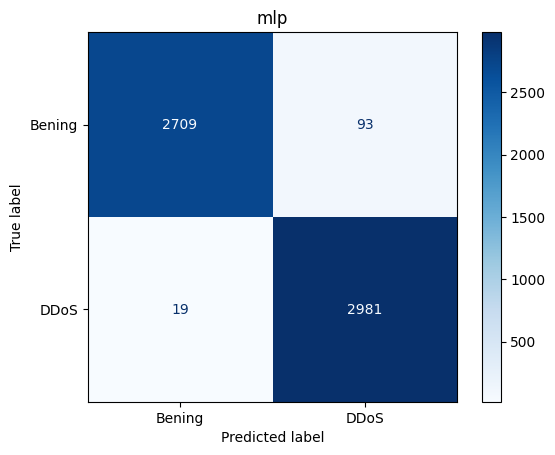


=== Test na zbiorze CICIDS2017 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.44      0.78      0.56     97718
           1       0.59      0.24      0.34    128027

    accuracy                           0.47    225745
   macro avg       0.51      0.51      0.45    225745
weighted avg       0.52      0.47      0.44    225745



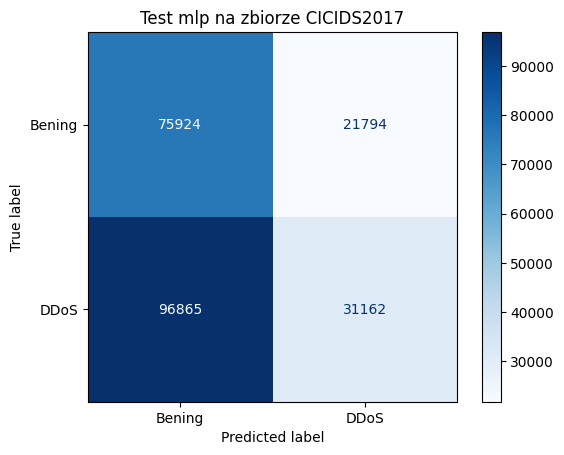


=== Analiza błędów: CICDDoS2019 → CICIDS2017 (mlp) ===

🔍 False Positives (FP):
                 count           mean           std  min    25%      50%  \
Flow Duration  21794.0  531922.910801  4.735227e+06 -1.0  283.0  34300.5   
Fwd IAT Total  21794.0  503566.225658  4.738693e+06  0.0    0.0     64.0   
Flow IAT Max   21794.0  373620.283885  1.550560e+06 -1.0  273.0  30627.0   
Idle Max       21794.0   50087.937735  1.114809e+06  0.0    0.0      0.0   
Flow IAT Min   21794.0   37915.346976  1.065988e+05 -1.0    4.0    144.0   

                     75%          max  
Flow Duration  115309.75  119998109.0  
Fwd IAT Total   49243.50  120000000.0  
Flow IAT Max    95802.75   51500000.0  
Idle Max            0.00   51500000.0  
Flow IAT Min    42790.50    1181307.0  

🔍 False Negatives (FN):
                 count          mean           std  min        25%        50%  \
Flow Duration  96865.0  2.189292e+07  3.419314e+07  1.0  1043498.0  3972838.0   
Fwd IAT Total  96865.0  2.132054e+0

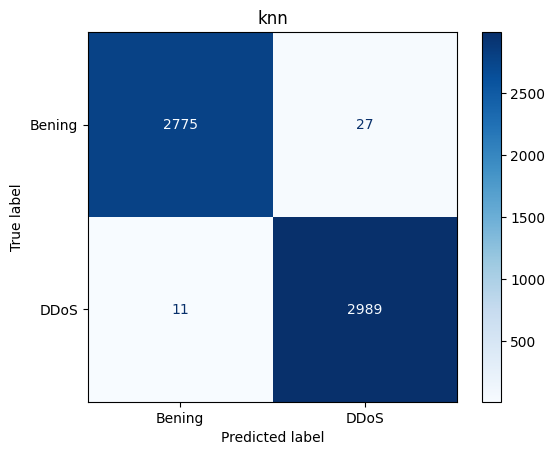


=== Test na zbiorze CICIDS2017 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.64      0.74      0.69     97718
           1       0.78      0.68      0.73    128027

    accuracy                           0.71    225745
   macro avg       0.71      0.71      0.71    225745
weighted avg       0.72      0.71      0.71    225745



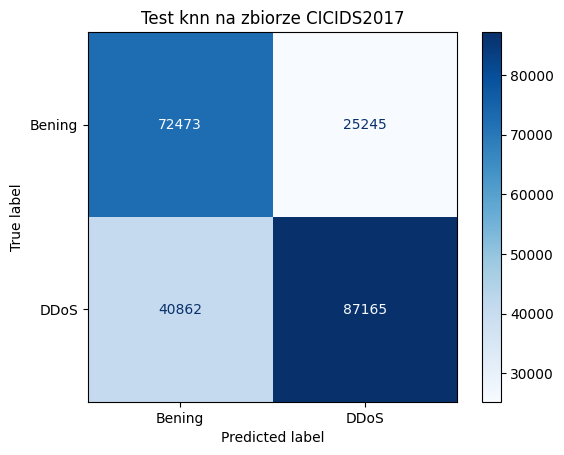


=== Analiza błędów: CICDDoS2019 → CICIDS2017 (knn) ===

🔍 False Positives (FP):
                 count          mean           std  min    25%    50%  \
Flow Duration  25245.0  1.056599e+06  8.145917e+06  0.0  183.0  238.0   
Fwd IAT Total  25245.0  1.008966e+06  8.052439e+06  0.0    3.0    4.0   
Flow IAT Max   25245.0  7.946516e+05  5.763366e+06  0.0  145.0  199.0   
Bwd IAT Total  25245.0  6.293497e+05  6.632222e+06  0.0    0.0    4.0   
Idle Max       25245.0  5.291914e+05  5.629399e+06  0.0    0.0    0.0   

                   75%          max  
Flow Duration  81832.0  119999937.0  
Fwd IAT Total  49943.0  120000000.0  
Flow IAT Max   61663.0  120000000.0  
Bwd IAT Total     48.0  120000000.0  
Idle Max           0.0  120000000.0  

🔍 False Negatives (FN):
                 count          mean           std  min         25%  \
Flow Duration  40862.0  4.830094e+07  3.942210e+07  0.0  9780181.75   
Fwd IAT Total  40862.0  4.781910e+07  3.922156e+07  0.0  9178267.75   
Flow IAT Max  

In [ ]:
for model_name in models_to_test:
    print(f"\n================= TEST: {model_name.upper()} (2019 → 2017) =================")
    run_full_experiment(df_2019, df_2017, stable, label_train='CICDDoS2019', label_test='CICIDS2017', model_type=model_name)


================= TEST: RANDOM_FOREST (2017 → 2019) =================

=== Model: RANDOM_FOREST | Trening na CICIDS2017 (90%), walidacja na CICIDS2017 (10%) ===
Wyniki walidacji:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9772
           1       1.00      1.00      1.00     12803

    accuracy                           1.00     22575
   macro avg       1.00      1.00      1.00     22575
weighted avg       1.00      1.00      1.00     22575



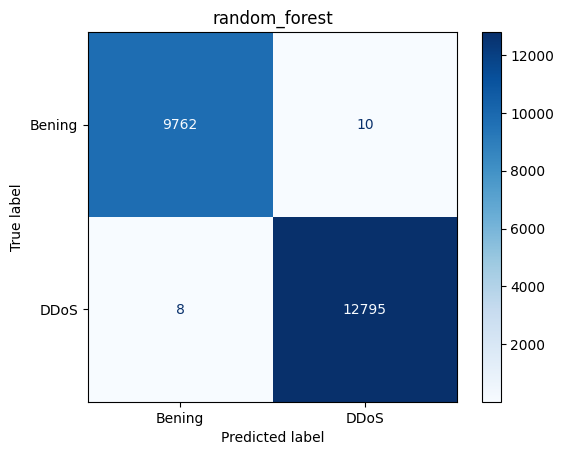


=== Test na zbiorze CICDDoS2019 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.48      1.00      0.65     28017
           1       0.89      0.00      0.00     30000

    accuracy                           0.48     58017
   macro avg       0.69      0.50      0.33     58017
weighted avg       0.69      0.48      0.32     58017



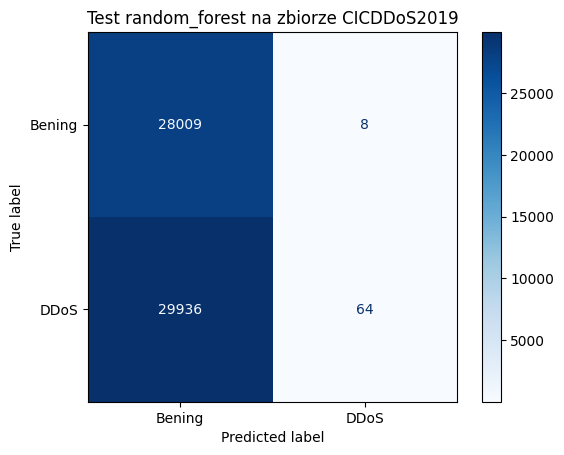


=== Analiza błędów: CICIDS2017 → CICDDoS2019 (random_forest) ===

🔍 False Positives (FP):
               count        mean           std      min       25%       50%  \
Flow Duration    8.0  3033558.00  4.232452e+06  54557.0  55449.75  143319.5   
Flow IAT Max     8.0  3027577.50  4.237262e+06  39094.0  46563.25  136663.0   
Fwd IAT Total    8.0  3006784.50  4.254016e+06   1712.0   2673.75  115405.0   
Fwd IAT Min      8.0  2977059.50  4.276989e+06      1.0      1.75       2.5   
Flow IAT Min     8.0  2977059.25  4.276989e+06      1.0      1.00       2.0   

                     75%         max  
Flow Duration  6556926.0  10493465.0  
Flow IAT Max   6556926.0  10493465.0  
Fwd IAT Total  6556926.0  10493465.0  
Fwd IAT Min    6556926.0  10493465.0  
Flow IAT Min   6556926.0  10493465.0  

🔍 False Negatives (FN):
                 count          mean           std  min  25%  50%   75%  \
Flow Duration  29936.0  1.214763e+06  1.084659e+07  0.0  1.0  1.0  48.0   
Fwd IAT Total  29936.0  1

/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:55:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Wyniki walidacji:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9772
           1       1.00      1.00      1.00     12803

    accuracy                           1.00     22575
   macro avg       1.00      1.00      1.00     22575
weighted avg       1.00      1.00      1.00     22575



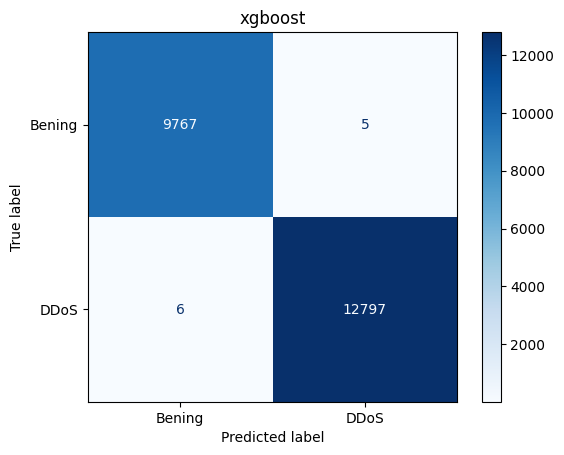


=== Test na zbiorze CICDDoS2019 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66     28017
           1       0.93      0.04      0.07     30000

    accuracy                           0.50     58017
   macro avg       0.71      0.52      0.36     58017
weighted avg       0.72      0.50      0.35     58017



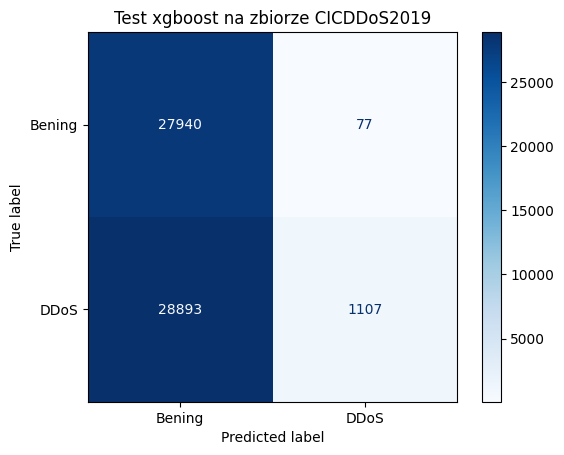


=== Analiza błędów: CICIDS2017 → CICDDoS2019 (xgboost) ===

🔍 False Positives (FP):
               count          mean           std      min       25%  \
Flow Duration   77.0  4.515477e+07  4.646570e+07  17980.0  499768.0   
Fwd IAT Total   77.0  4.514864e+07  4.647173e+07      2.0  499768.0   
Flow IAT Max    77.0  1.153580e+07  1.476815e+07   3293.0  499767.0   
Idle Max        77.0  9.917126e+06  9.021072e+06      0.0       0.0   
Fwd IAT Min     77.0  1.567881e+06  1.800087e+06      0.0       1.0   

                      50%          75%          max  
Flow Duration  38860131.0  105805328.0  119657359.0  
Fwd IAT Total  38860131.0  105805328.0  119657359.0  
Flow IAT Max   13784715.0   17088768.0  114264106.0  
Idle Max       13597284.0   17054824.0   44730193.0  
Fwd IAT Min     2036838.0    2565368.0   10493465.0  

🔍 False Negatives (FN):
                 count          mean           std  min  25%  50%   75%  \
Flow Duration  28893.0  1.258113e+06  1.103811e+07  0.0  1.0  1.

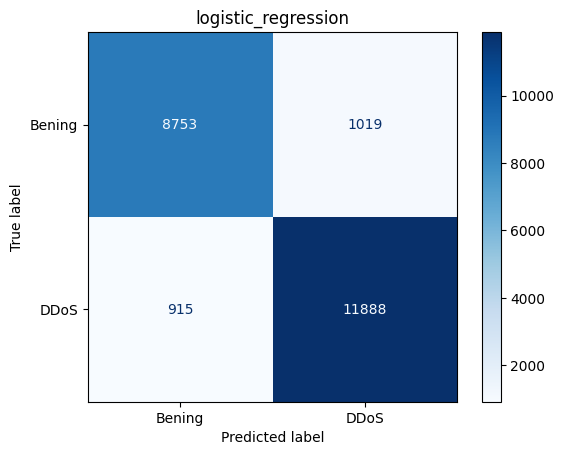


=== Test na zbiorze CICDDoS2019 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.58      0.97      0.72     28017
           1       0.91      0.34      0.50     30000

    accuracy                           0.64     58017
   macro avg       0.75      0.65      0.61     58017
weighted avg       0.75      0.64      0.60     58017



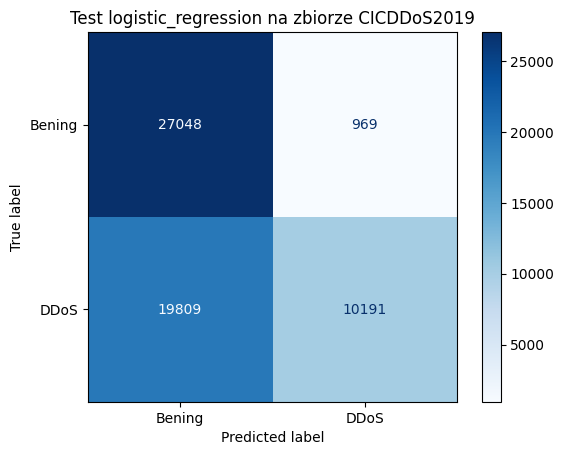


=== Analiza błędów: CICIDS2017 → CICDDoS2019 (logistic_regression) ===

🔍 False Positives (FP):
               count          mean           std      min        25%  \
Flow Duration  969.0  1.726950e+07  2.439905e+07  42481.0  5195398.0   
Fwd IAT Total  969.0  1.674064e+07  2.391441e+07      0.0  5139332.0   
Flow IAT Max   969.0  1.631915e+07  2.337031e+07  20716.0  5010001.0   
Idle Max       969.0  1.050654e+07  2.013071e+07      0.0        0.0   
Bwd IAT Total  969.0  6.900623e+05  6.411661e+06      0.0        2.0   

                     50%        75%          max  
Flow Duration  5702724.0  9029956.0  119991913.0  
Fwd IAT Total  5661462.0  9028458.0  119991913.0  
Flow IAT Max   5568930.0  6842100.0  119948019.0  
Idle Max             0.0  6000417.0  111950464.0  
Bwd IAT Total        3.0   133524.0  109011164.0  

🔍 False Negatives (FN):
                 count          mean           std  min  25%  50%    75%  \
Flow Duration  19809.0  1.790859e+06  1.319258e+07  0.0  1.0  1

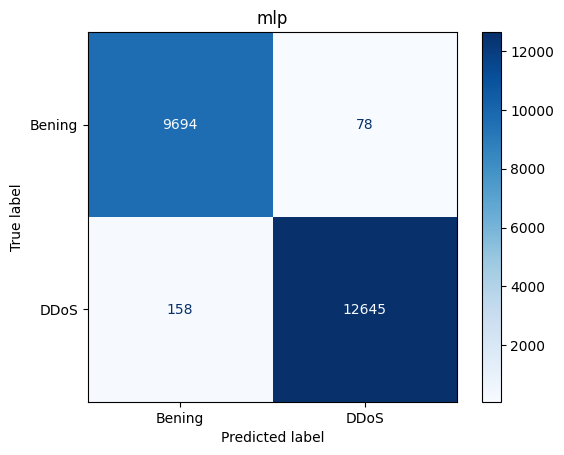


=== Test na zbiorze CICDDoS2019 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.57      0.98      0.72     28017
           1       0.94      0.31      0.47     30000

    accuracy                           0.63     58017
   macro avg       0.76      0.65      0.60     58017
weighted avg       0.76      0.63      0.59     58017



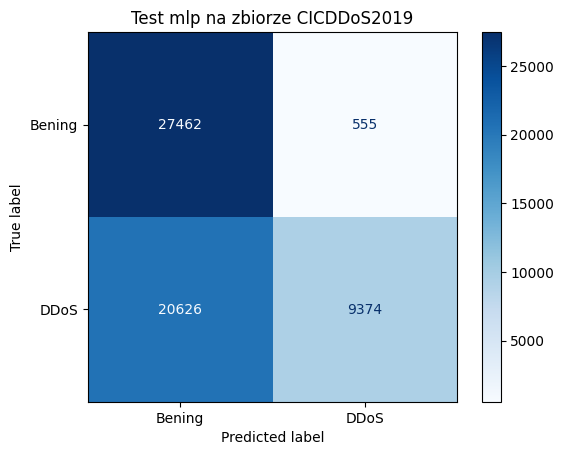


=== Analiza błędów: CICIDS2017 → CICDDoS2019 (mlp) ===

🔍 False Positives (FP):
               count          mean           std      min        25%  \
Flow Duration  555.0  2.901813e+07  3.800296e+07  54428.0  5264748.5   
Fwd IAT Total  555.0  2.900751e+07  3.801080e+07      1.0  5264748.5   
Flow IAT Max   555.0  2.111816e+07  2.443840e+07  34691.0  5205573.0   
Idle Max       555.0  1.872346e+07  2.597456e+07      0.0        0.0   
Bwd IAT Total  555.0  8.193019e+06  2.037753e+07      0.0        1.0   

                     50%         75%          max  
Flow Duration  6825898.0  53756626.0  119995269.0  
Fwd IAT Total  6825898.0  53756626.0  119995269.0  
Flow IAT Max   5990106.0  53684202.0  111950464.0  
Idle Max       5906262.0  53684202.0  111950464.0  
Bwd IAT Total        2.0         3.0   86943219.0  

🔍 False Negatives (FN):
                 count          mean           std  min  25%  50%   75%  \
Flow Duration  20626.0  1.693803e+06  1.280979e+07  0.0  1.0  1.0  99.0   

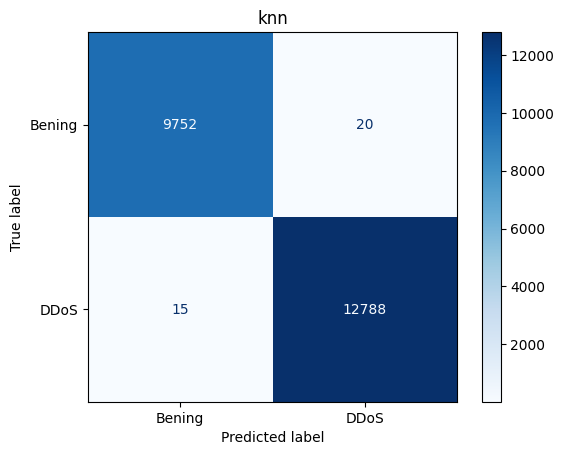


=== Test na zbiorze CICDDoS2019 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.56      0.99      0.71     28017
           1       0.97      0.27      0.42     30000

    accuracy                           0.62     58017
   macro avg       0.76      0.63      0.57     58017
weighted avg       0.77      0.62      0.56     58017



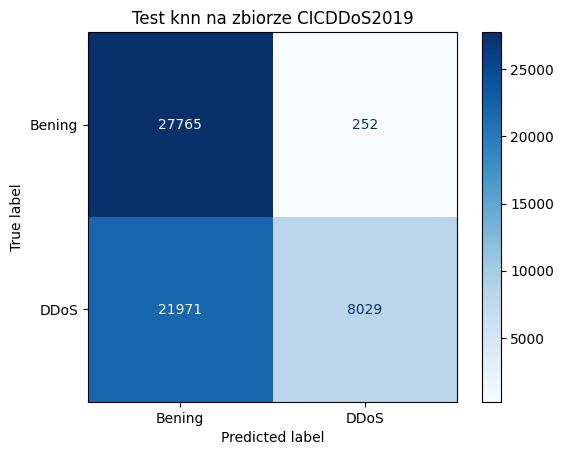


=== Analiza błędów: CICIDS2017 → CICDDoS2019 (knn) ===

🔍 False Positives (FP):
               count          mean           std      min         25%  \
Flow Duration  252.0  2.469474e+07  2.492958e+07  64672.0  9006987.50   
Fwd IAT Total  252.0  2.467377e+07  2.494946e+07      1.0  9006987.50   
Flow IAT Max   252.0  2.226297e+07  2.398981e+07  21436.0  6000382.50   
Idle Max       252.0  1.948634e+07  2.486563e+07      0.0  5907584.25   
Bwd IAT Total  252.0  2.903020e+05  8.134726e+05      0.0        0.00   

                     50%         75%          max  
Flow Duration  9027946.5  53756316.5  119848275.0  
Fwd IAT Total  9027946.5  53756316.5  119848275.0  
Flow IAT Max   6015612.0  53680603.0  111950464.0  
Idle Max       6006025.0  53680603.0  111950464.0  
Bwd IAT Total        0.0         3.0    6069651.0  

🔍 False Negatives (FN):
                 count          mean           std  min  25%  50%   75%  \
Flow Duration  21971.0  1.638487e+06  1.261268e+07  0.0  1.0  1.0  5

In [ ]:
for model_name in models_to_test:
    print(f"\n================= TEST: {model_name.upper()} (2017 → 2019) =================")
    run_full_experiment(df_2017, df_2019, stable, label_train='CICIDS2017', label_test='CICDDoS2019', model_type=model_name)


================= TEST: RANDOM_FOREST (2019 → 2017) =================

=== Model: RANDOM_FOREST | Trening na CICDDoS2019 (90%), walidacja na CICDDoS2019 (10%) ===
Wyniki walidacji:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      2802
           1       0.89      0.98      0.93      3000

    accuracy                           0.93      5802
   macro avg       0.93      0.93      0.93      5802
weighted avg       0.93      0.93      0.93      5802



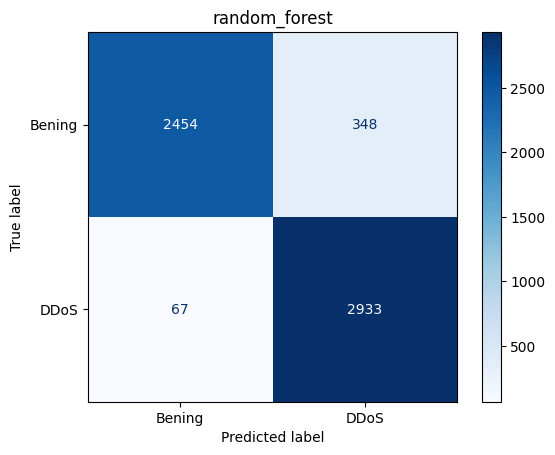


=== Test na zbiorze CICIDS2017 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.44      0.94      0.60     97718
           1       0.62      0.07      0.13    128027

    accuracy                           0.45    225745
   macro avg       0.53      0.51      0.36    225745
weighted avg       0.54      0.45      0.33    225745



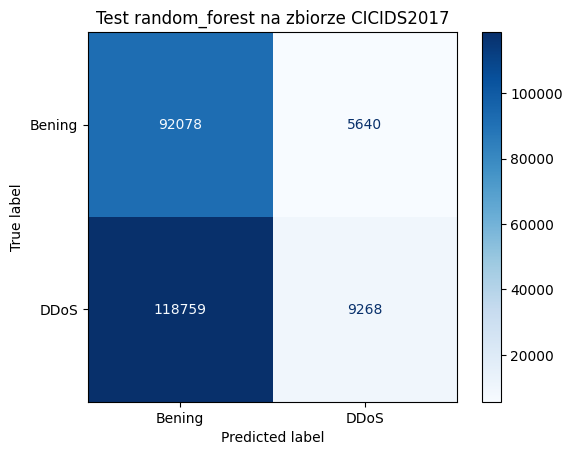


=== Analiza błędów: CICDDoS2019 → CICIDS2017 (random_forest) ===

🔍 False Positives (FP):
                count          mean           std  min    25%    50%    75%  \
Flow Duration  5640.0  1.127136e+06  1.106185e+07 -1.0  46.75  132.0  322.0   
Bwd IAT Mean   5640.0  7.617103e+04  1.482828e+06  0.0   0.00    0.0    0.0   
Fwd IAT Min    5640.0  1.737553e+03  5.121722e+03  0.0   4.00  102.0  273.0   
Flow IAT Min   5640.0  1.735232e+03  5.117932e+03 -1.0   4.00  104.0  273.0   
Bwd Packets/s  5640.0  1.216256e+03  5.065891e+03  0.0   0.00    0.0    0.0   

                        max  
Flow Duration  1.199999e+08  
Bwd IAT Mean   5.810000e+07  
Fwd IAT Min    3.588100e+04  
Flow IAT Min   3.588100e+04  
Bwd Packets/s  8.695652e+04  

🔍 False Negatives (FN):
                  count          mean           std   min       25%  \
Flow Duration  118759.0  1.706211e+07  3.103815e+07   1.0  571027.0   
Bwd IAT Mean   118759.0  1.182978e+05  1.544502e+05   0.0       0.0   
Fwd IAT Min    1

/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:21:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Wyniki walidacji:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      2802
           1       0.89      0.98      0.93      3000

    accuracy                           0.93      5802
   macro avg       0.94      0.93      0.93      5802
weighted avg       0.93      0.93      0.93      5802



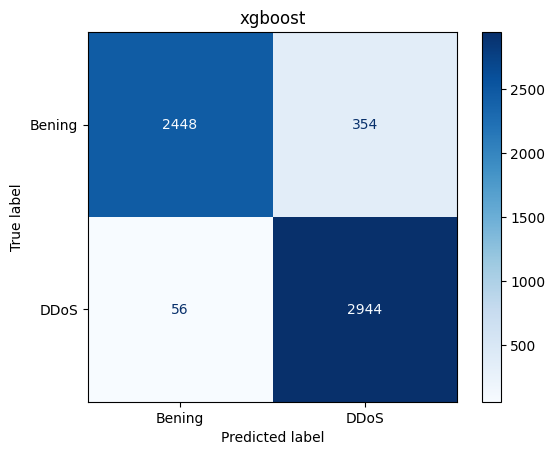


=== Test na zbiorze CICIDS2017 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.46      0.95      0.62     97718
           1       0.79      0.14      0.23    128027

    accuracy                           0.49    225745
   macro avg       0.62      0.54      0.43    225745
weighted avg       0.65      0.49      0.40    225745



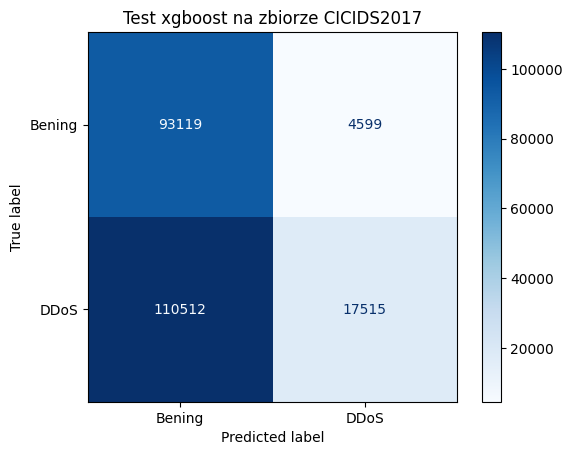


=== Analiza błędów: CICDDoS2019 → CICIDS2017 (xgboost) ===

🔍 False Positives (FP):
                count          mean           std  min   25%   50%    75%  \
Flow Duration  4599.0  4.760915e+06  2.115085e+07 -1.0  15.0  90.0  175.0   
Bwd IAT Mean   4599.0  5.520478e+05  2.793419e+06  0.0   0.0   0.0    0.0   
Bwd Packets/s  4599.0  1.843653e+03  6.481727e+03  0.0   0.0   0.0    0.0   
Fwd IAT Min    4599.0  1.318530e+02  1.597888e+03  0.0   3.0  49.0  143.0   
Flow IAT Min   4599.0  7.502392e+01  8.447753e+01 -1.0   2.0  48.0  135.0   

                        max  
Flow Duration  1.199999e+08  
Bwd IAT Mean   5.810000e+07  
Bwd Packets/s  8.695652e+04  
Fwd IAT Min    7.779100e+04  
Flow IAT Min   2.900000e+02  

🔍 False Negatives (FN):
                  count          mean           std   min       25%  \
Flow Duration  110512.0  1.102821e+07  2.394594e+07   1.0  498521.5   
Bwd IAT Mean   110512.0  1.063981e+05  1.483348e+05   0.0       0.0   
Fwd IAT Min    110512.0  3.065854e

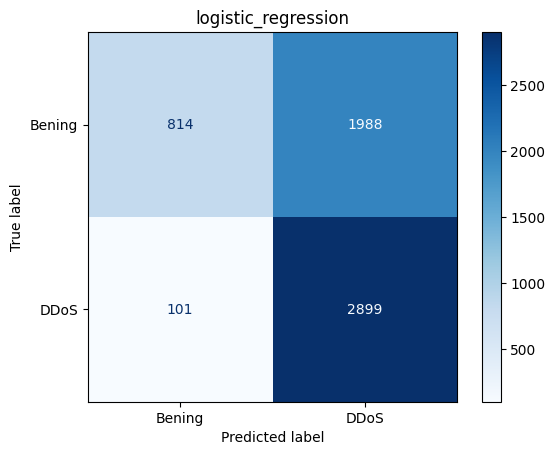


=== Test na zbiorze CICIDS2017 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69     97718
           1       0.76      0.82      0.78    128027

    accuracy                           0.75    225745
   macro avg       0.74      0.73      0.74    225745
weighted avg       0.74      0.75      0.74    225745



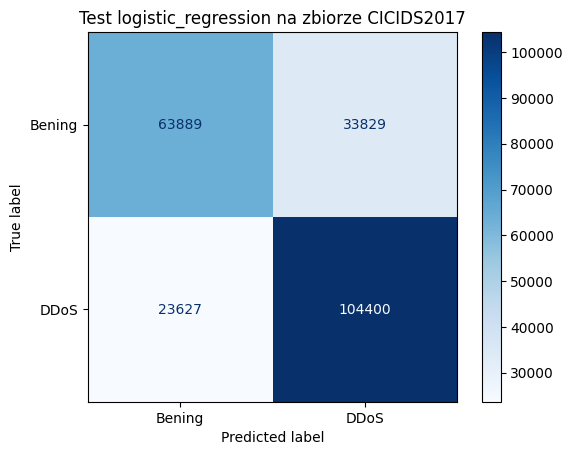


=== Analiza błędów: CICDDoS2019 → CICIDS2017 (logistic_regression) ===

🔍 False Positives (FP):
                 count           mean           std  min           25%  \
Flow Duration  33829.0  819295.172101  1.642511e+06 -1.0  12038.000000   
Bwd IAT Mean   33829.0   40089.086113  1.071870e+05  0.0      0.000000   
Fwd IAT Min    33829.0     323.426468  2.209055e+03  0.0      2.000000   
Bwd Packets/s  33829.0     102.094074  3.893956e+02  0.0      0.755917   
Flow IAT Min   33829.0      49.252712  1.874304e+02 -1.0      2.000000   

                        50%            75%           max  
Flow Duration  71183.000000  727031.000000  1.622358e+07  
Bwd IAT Mean       4.000000   11420.000000  6.199850e+05  
Fwd IAT Min        4.000000      48.000000  2.859400e+04  
Bwd Packets/s      8.308672      41.017227  3.164557e+03  
Flow IAT Min       3.000000      12.000000  3.030000e+03  

🔍 False Negatives (FN):
                 count          mean           std  min           25%  \
Flow D

/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Wyniki walidacji:
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      2802
           1       0.84      0.97      0.90      3000

    accuracy                           0.89      5802
   macro avg       0.90      0.88      0.89      5802
weighted avg       0.90      0.89      0.89      5802



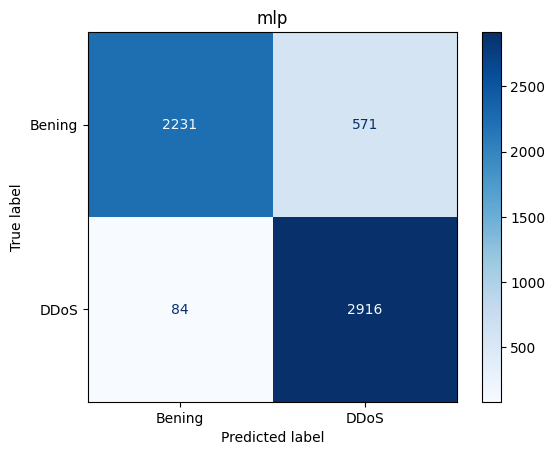


=== Test na zbiorze CICIDS2017 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.41      0.89      0.56     97718
           1       0.26      0.03      0.05    128027

    accuracy                           0.40    225745
   macro avg       0.34      0.46      0.31    225745
weighted avg       0.33      0.40      0.27    225745



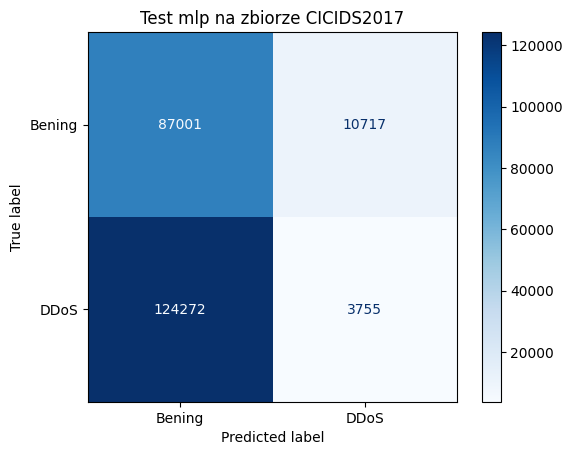


=== Analiza błędów: CICDDoS2019 → CICIDS2017 (mlp) ===

🔍 False Positives (FP):
                 count          mean           std  min  25%    50%  \
Flow Duration  10717.0  2.799384e+07  4.379448e+07 -1.0  5.0  227.0   
Bwd IAT Mean   10717.0  3.422460e+06  5.455893e+06  0.0  0.0    0.0   
Fwd IAT Min    10717.0  6.722067e+02  3.213611e+03  0.0  3.0   33.0   
Flow IAT Min   10717.0  3.229468e+02  1.341252e+03 -1.0  1.0    3.0   
pred           10717.0  1.000000e+00  0.000000e+00  1.0  1.0    1.0   

                      75%          max  
Flow Duration  91001975.0  119991573.0  
Bwd IAT Mean   10800000.0   40000000.0  
Fwd IAT Min         175.0      42004.0  
Flow IAT Min         96.0      12332.0  
pred                  1.0          1.0  

🔍 False Negatives (FN):
                  count          mean           std   min        25%  \
Flow Duration  124272.0  1.532945e+07  2.922517e+07   1.0  609664.25   
Bwd IAT Mean   124272.0  1.149366e+05  1.543127e+05   0.0       0.00   
Fwd I

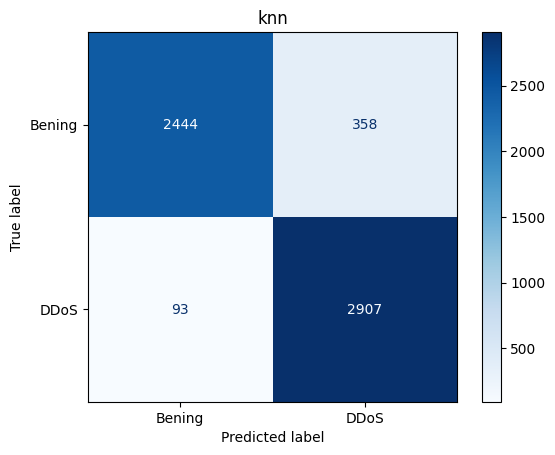


=== Test na zbiorze CICIDS2017 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.44      0.89      0.59     97718
           1       0.63      0.14      0.24    128027

    accuracy                           0.47    225745
   macro avg       0.53      0.52      0.41    225745
weighted avg       0.55      0.47      0.39    225745



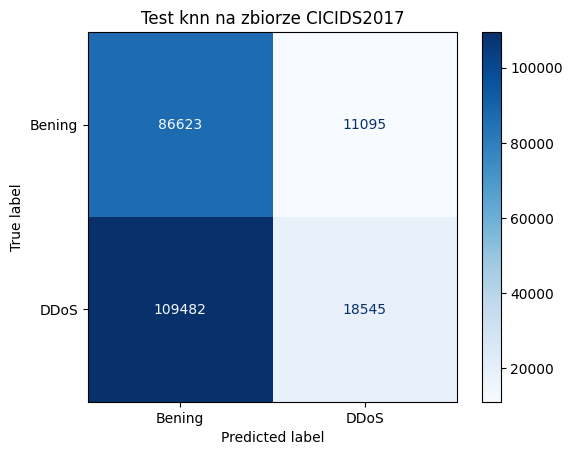


=== Analiza błędów: CICDDoS2019 → CICIDS2017 (knn) ===

🔍 False Positives (FP):
                 count          mean           std  min    25%         50%  \
Flow Duration  11095.0  3.806238e+07  4.465740e+07 -1.0  129.0  6973.00000   
Bwd IAT Mean   11095.0  5.391047e+06  8.562903e+06  0.0    0.0     0.00000   
Fwd IAT Min    11095.0  2.539757e+03  5.633819e+04  0.0    4.0    48.00000   
Bwd Packets/s  11095.0  6.902903e+02  4.411895e+03  0.0    0.0     0.08858   
Flow IAT Min   11095.0  2.602058e+02  1.573650e+03 -3.0    1.0     4.00000   

                        75%          max  
Flow Duration  8.586503e+07  119991573.0  
Bwd IAT Mean   1.030000e+07   59200000.0  
Fwd IAT Min    1.870000e+02    3589907.0  
Bwd Packets/s  1.094174e-01      40000.0  
Flow IAT Min   1.000000e+02      61645.0  

🔍 False Negatives (FN):
                  count          mean           std   min        25%  \
Flow Duration  109482.0  1.049274e+07  2.369221e+07   1.0  519434.25   
Bwd IAT Mean   109482.0

In [ ]:
for model_name in models_to_test:
    print(f"\n================= TEST: {model_name.upper()} (2019 → 2017) =================")
    run_full_experiment(df_2019, df_2017, stable_2019, label_train='CICDDoS2019', label_test='CICIDS2017', model_type=model_name)


================= TEST: RANDOM_FOREST (2017 → 2019) =================

=== Model: RANDOM_FOREST | Trening na CICIDS2017 (90%), walidacja na CICIDS2017 (10%) ===
Wyniki walidacji:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9772
           1       1.00      1.00      1.00     12803

    accuracy                           1.00     22575
   macro avg       1.00      1.00      1.00     22575
weighted avg       1.00      1.00      1.00     22575



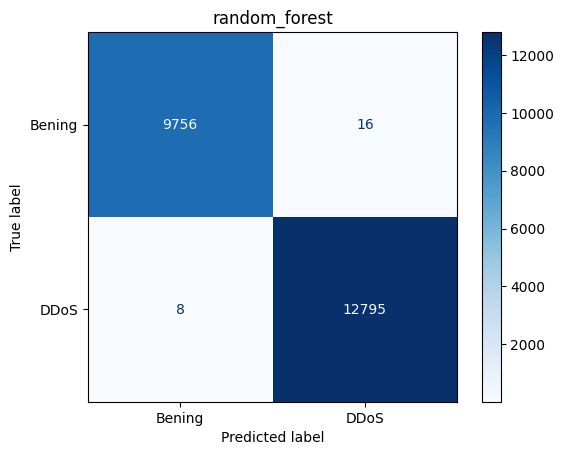


=== Test na zbiorze CICDDoS2019 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67     28017
           1       1.00      0.09      0.16     30000

    accuracy                           0.53     58017
   macro avg       0.75      0.54      0.42     58017
weighted avg       0.76      0.53      0.41     58017



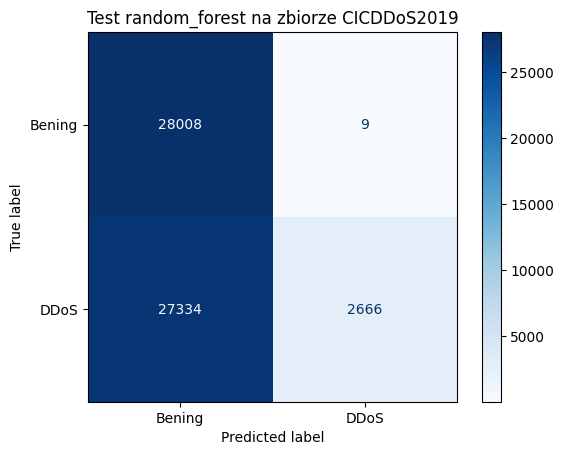


=== Analiza błędów: CICIDS2017 → CICDDoS2019 (random_forest) ===

🔍 False Positives (FP):
               count          mean           std  min  25%  50%           75%  \
Fwd IAT Total    9.0  6.692723e+06  2.007250e+07  2.0  2.0  3.0   2085.000000   
Flow IAT Max     9.0  6.674058e+06  2.001610e+07  1.0  1.0  1.0   3293.000000   
Idle Max         9.0  6.672259e+06  2.001678e+07  0.0  0.0  0.0      0.000000   
Bwd IAT Total    9.0  2.452800e+04  4.762507e+04  0.0  0.0  0.0  26941.000000   
Bwd IAT Std      9.0  8.819980e+02  1.690556e+03  0.0  0.0  0.0   1187.612143   

                        max  
Fwd IAT Total  6.021938e+07  
Flow IAT Max   6.005033e+07  
Idle Max       6.005033e+07  
Bwd IAT Total  1.419200e+05  
Bwd IAT Std    5.059073e+03  

🔍 False Negatives (FN):
                 count          mean           std  min  25%  50%  75%  \
Fwd IAT Total  27334.0  1.329613e+06  1.134426e+07  0.0  1.0  1.0  2.0   
Flow IAT Max   27334.0  3.830743e+05  3.333060e+06  0.0  1.0  1.0  2.

/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:26:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Wyniki walidacji:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9772
           1       1.00      1.00      1.00     12803

    accuracy                           1.00     22575
   macro avg       1.00      1.00      1.00     22575
weighted avg       1.00      1.00      1.00     22575



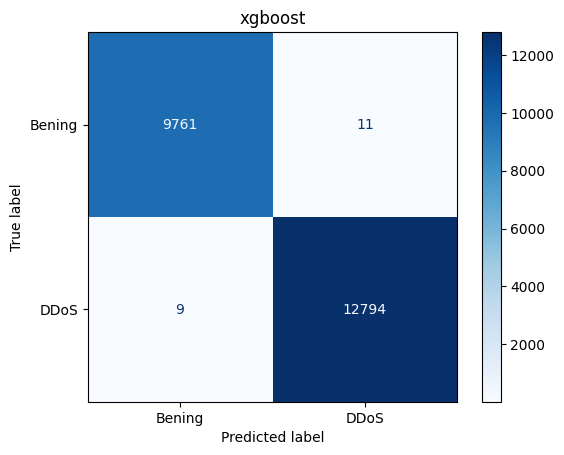


=== Test na zbiorze CICDDoS2019 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67     28017
           1       0.99      0.10      0.18     30000

    accuracy                           0.53     58017
   macro avg       0.75      0.55      0.43     58017
weighted avg       0.76      0.53      0.42     58017



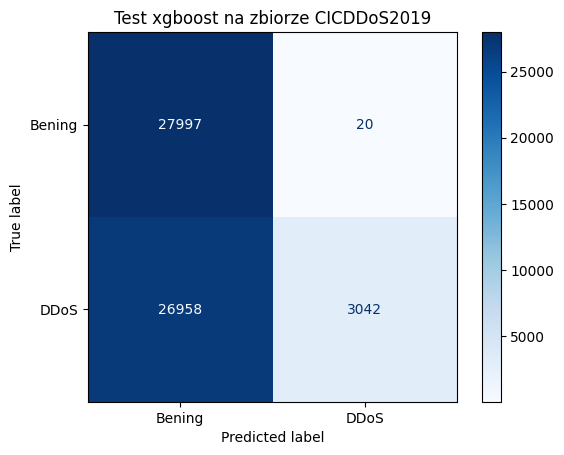


=== Analiza błędów: CICIDS2017 → CICDDoS2019 (xgboost) ===

🔍 False Positives (FP):
               count          mean           std    min      25%  \
Fwd IAT Total   20.0  6.821090e+06  1.351102e+07    0.0   2707.0   
Flow IAT Max    20.0  6.589829e+06  1.349573e+07  154.0  38772.0   
Idle Max        20.0  6.229336e+06  1.363899e+07    0.0      0.0   
Bwd IAT Total   20.0  8.070040e+04  2.289443e+05    0.0      0.0   
Bwd IAT Std     20.0  1.451713e+04  4.481356e+04    0.0      0.0   

                        50%           75%           max  
Fwd IAT Total  576482.00000  7.350860e+06  4.482691e+07  
Flow IAT Max   490689.50000  6.915684e+06  4.473019e+07  
Idle Max            0.00000  6.915684e+06  4.473019e+07  
Bwd IAT Total   35562.50000  5.304225e+04  1.046265e+06  
Bwd IAT Std      1756.44256  9.434632e+03  2.032734e+05  

🔍 False Negatives (FN):
                 count          mean           std  min  25%  50%  75%  \
Fwd IAT Total  26958.0  1.348158e+06  1.142201e+07  0.0  1.

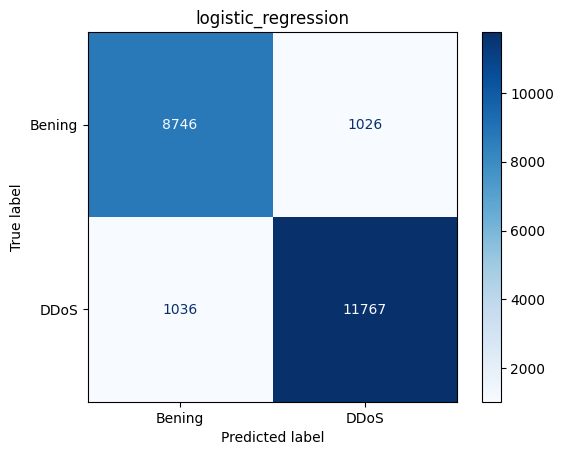


=== Test na zbiorze CICDDoS2019 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.58      0.97      0.72     28017
           1       0.93      0.33      0.49     30000

    accuracy                           0.64     58017
   macro avg       0.75      0.65      0.61     58017
weighted avg       0.76      0.64      0.60     58017



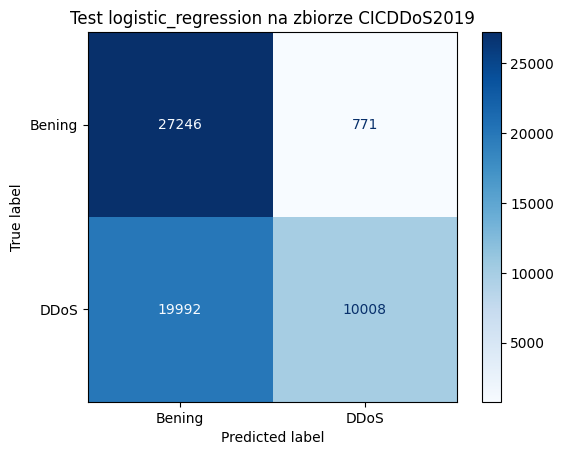


=== Analiza błędów: CICIDS2017 → CICDDoS2019 (logistic_regression) ===

🔍 False Positives (FP):
               count          mean           std      min        25%  \
Fwd IAT Total  771.0  1.277222e+07  2.265250e+07      0.0  5061663.5   
Flow IAT Max   771.0  1.273489e+07  2.159683e+07  20970.0  5002897.5   
Idle Max       771.0  5.522029e+06  1.523757e+07      0.0        0.0   
Bwd IAT Total  771.0  1.001949e+06  6.923241e+06      0.0        2.0   
Bwd IAT Std    771.0  3.890637e+05  4.021738e+06      0.0        0.0   

                        50%           75%           max  
Fwd IAT Total  5.449002e+06  5.953116e+06  1.199919e+08  
Flow IAT Max   5.373708e+06  5.921424e+06  1.199480e+08  
Idle Max       0.000000e+00  5.107368e+06  1.119505e+08  
Bwd IAT Total  2.901300e+04  1.854860e+05  1.090112e+08  
Bwd IAT Std    7.597639e+03  2.497374e+04  7.708253e+07  

🔍 False Negatives (FN):
                 count          mean           std  min  25%  50%    75%  \
Fwd IAT Total  19992.

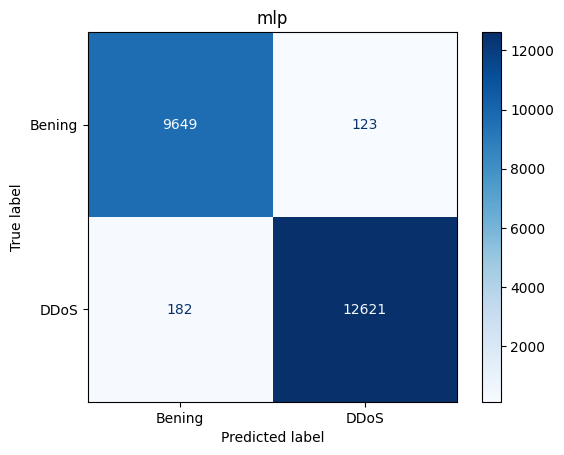


=== Test na zbiorze CICDDoS2019 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.48      1.00      0.65     28017
           1       0.65      0.01      0.01     30000

    accuracy                           0.48     58017
   macro avg       0.56      0.50      0.33     58017
weighted avg       0.57      0.48      0.32     58017



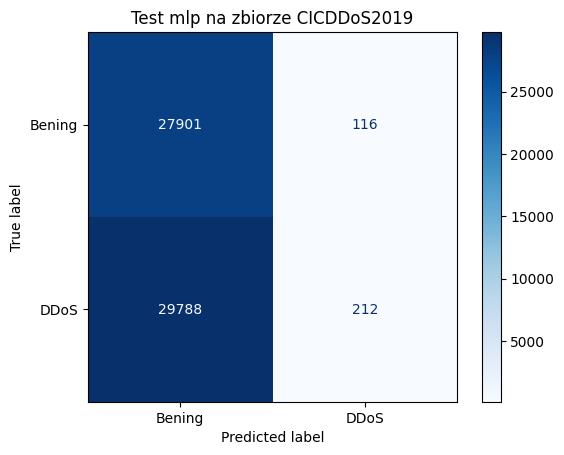


=== Analiza błędów: CICIDS2017 → CICDDoS2019 (mlp) ===

🔍 False Positives (FP):
               count          mean           std       min         25%  \
Fwd IAT Total  116.0  1.475236e+07  2.479908e+07       1.0  5039527.75   
Flow IAT Max   116.0  1.438652e+07  2.392995e+07  137944.0  4995538.00   
Idle Max       116.0  1.186420e+07  2.505166e+07       0.0        0.00   
Bwd IAT Total  116.0  1.812341e+05  1.052595e+06       0.0        1.00   
Bwd IAT Std    116.0  4.080680e+04  3.105085e+05       0.0        0.00   

                     50%         75%           max  
Fwd IAT Total  5059616.0  6061385.50  1.176648e+08  
Flow IAT Max   5007489.0  5973906.00  1.119505e+08  
Idle Max             0.0  5973906.00  1.119505e+08  
Bwd IAT Total        3.0       10.75  1.116154e+07  
Bwd IAT Std          0.0        0.00  3.338383e+06  

🔍 False Negatives (FN):
                 count          mean           std  min  25%  50%   75%  \
Fwd IAT Total  29788.0  1.207383e+06  1.085583e+07  0.0 

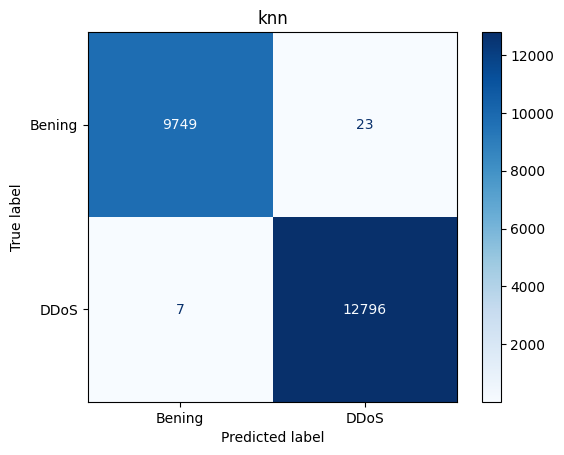


=== Test na zbiorze CICDDoS2019 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.56      1.00      0.72     28017
           1       0.99      0.27      0.43     30000

    accuracy                           0.62     58017
   macro avg       0.78      0.64      0.57     58017
weighted avg       0.78      0.62      0.57     58017



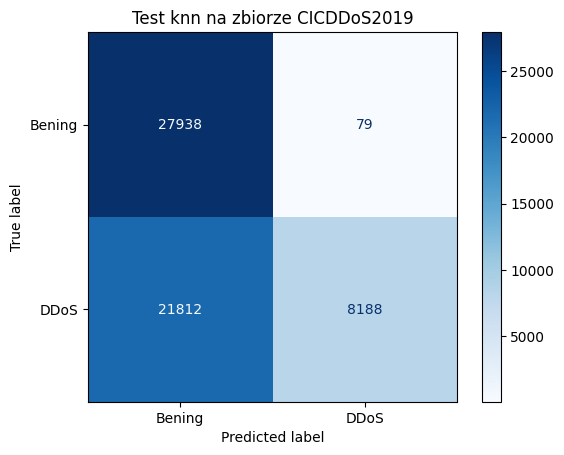


=== Analiza błędów: CICIDS2017 → CICDDoS2019 (knn) ===

🔍 False Positives (FP):
               count          mean           std  min        25%  \
Fwd IAT Total   79.0  2.724814e+07  3.030384e+07  2.0  5833739.5   
Flow IAT Max    79.0  2.434744e+07  2.662676e+07  1.0  5357842.5   
Idle Max        79.0  1.598394e+07  2.855171e+07  0.0        0.0   
Bwd IAT Total   79.0  8.799761e+05  1.249039e+06  0.0        0.0   
Bwd IAT Std     79.0  5.413027e+04  1.731063e+05  0.0        0.0   

                        50%           75%           max  
Fwd IAT Total  2.592924e+07  3.005847e+07  1.198483e+08  
Flow IAT Max   2.464314e+07  2.904713e+07  1.119505e+08  
Idle Max       0.000000e+00  1.288077e+07  1.119505e+08  
Bwd IAT Total  2.724500e+05  1.080864e+06  6.069651e+06  
Bwd IAT Std    1.540299e+04  4.332999e+04  1.495036e+06  

🔍 False Negatives (FN):
                 count          mean           std  min  25%  50%   75%  \
Fwd IAT Total  21812.0  1.654362e+06  1.265783e+07  0.0  1.0  

In [ ]:
for model_name in models_to_test:
    print(f"\n================= TEST: {model_name.upper()} (2017 → 2019) =================")
    run_full_experiment(df_2017, df_2019, stable_2017, label_train='CICIDS2017', label_test='CICDDoS2019', model_type=model_name)


================= TEST: RANDOM_FOREST (2019 → 2017) =================

=== Model: RANDOM_FOREST | Trening na CICDDoS2019 (90%), walidacja na CICDDoS2019 (10%) ===
Wyniki walidacji:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2802
           1       0.99      1.00      0.99      3000

    accuracy                           0.99      5802
   macro avg       0.99      0.99      0.99      5802
weighted avg       0.99      0.99      0.99      5802



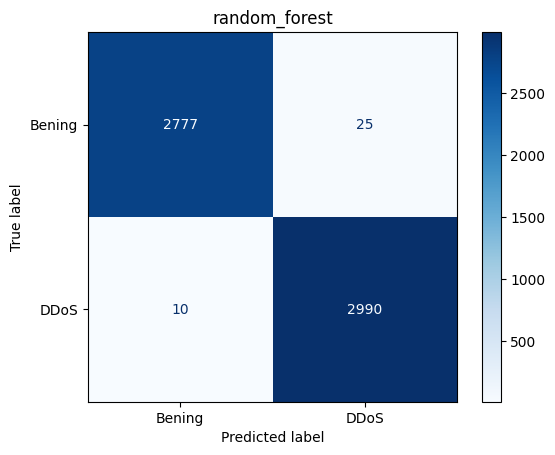


=== Test na zbiorze CICIDS2017 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.42      0.93      0.58     97718
           1       0.01      0.00      0.00    128027

    accuracy                           0.40    225745
   macro avg       0.22      0.47      0.29    225745
weighted avg       0.19      0.40      0.25    225745



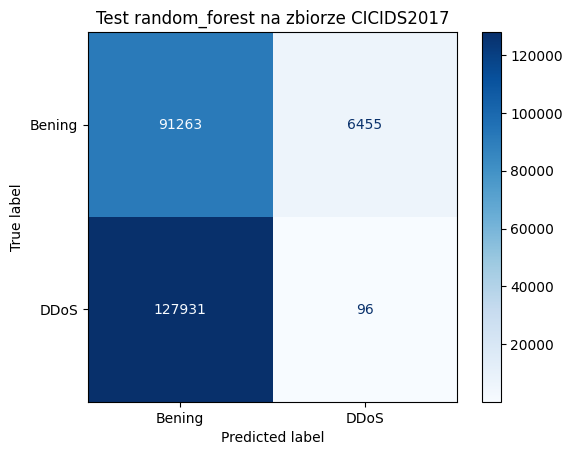


=== Analiza błędów: CICDDoS2019 → CICIDS2017 (random_forest) ===

🔍 False Positives (FP):
                count           mean           std  min   25%    50%    75%  \
Fwd IAT Total  6455.0  863407.030829  8.500604e+06  0.0   1.0   48.0  124.0   
Flow IAT Max   6455.0  345734.133075  1.830274e+06 -1.0  67.0  110.0  175.0   
Idle Max       6455.0  125879.284586  1.518678e+06  0.0   0.0    0.0    0.0   
Bwd IAT Total  6455.0    5750.502401  1.741935e+05  0.0   0.0    0.0    3.0   
Bwd IAT Std    6455.0    2150.688900  6.538397e+04  0.0   0.0    0.0    0.0   

                        max  
Fwd IAT Total  1.200000e+08  
Flow IAT Max   2.830000e+07  
Idle Max       2.830000e+07  
Bwd IAT Total  5.318224e+06  
Bwd IAT Std    2.205794e+06  

🔍 False Negatives (FN):
                  count          mean           std  min       25%  \
Fwd IAT Total  127931.0  1.652909e+07  3.093268e+07  0.0    3557.0   
Flow IAT Max   127931.0  1.584969e+07  2.867511e+07  1.0  606476.0   
Idle Max       1279

/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:04:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Wyniki walidacji:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2802
           1       0.99      1.00      0.99      3000

    accuracy                           0.99      5802
   macro avg       0.99      0.99      0.99      5802
weighted avg       0.99      0.99      0.99      5802



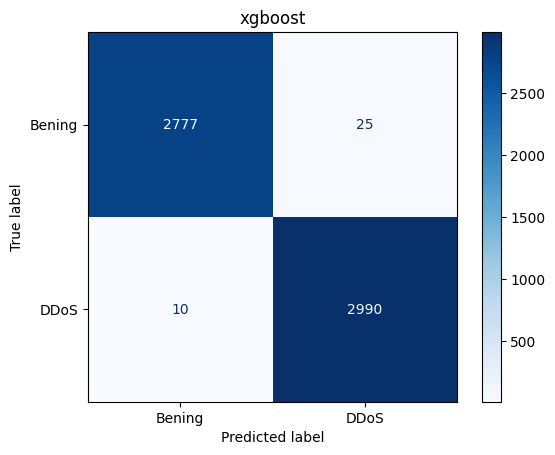


=== Test na zbiorze CICIDS2017 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.43      0.95      0.59     97718
           1       0.57      0.05      0.10    128027

    accuracy                           0.44    225745
   macro avg       0.50      0.50      0.35    225745
weighted avg       0.51      0.44      0.31    225745



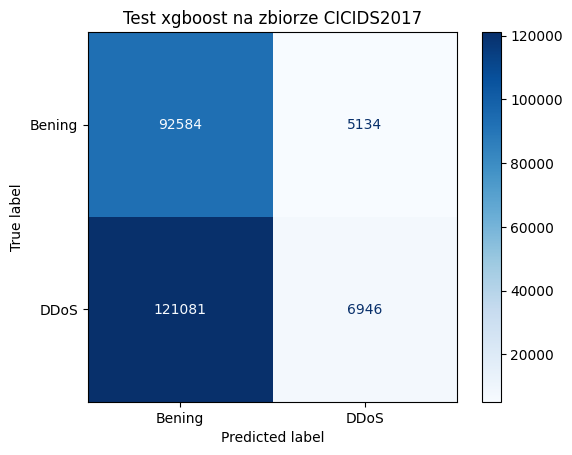


=== Analiza błędów: CICDDoS2019 → CICIDS2017 (xgboost) ===

🔍 False Positives (FP):
                count           mean           std  min   25%    50%    75%  \
Fwd IAT Total  5134.0  919159.879042  9.504642e+06  0.0   3.0   48.0   96.0   
Flow IAT Max   5134.0  245656.873198  1.823262e+06 -1.0  58.0  105.0  127.0   
Idle Max       5134.0  178096.577133  1.764917e+06  0.0   0.0    0.0    0.0   
Bwd IAT Total  5134.0    7167.133814  1.825341e+05  0.0   0.0    0.0   48.0   
Bwd IAT Std    5134.0    2554.002994  7.020239e+04  0.0   0.0    0.0    0.0   

                        max  
Fwd IAT Total  1.200000e+08  
Flow IAT Max   2.830000e+07  
Idle Max       2.830000e+07  
Bwd IAT Total  5.295514e+06  
Bwd IAT Std    2.858060e+06  

🔍 False Negatives (FN):
                  count          mean           std  min       25%  \
Fwd IAT Total  121081.0  1.717307e+07  3.166920e+07  0.0    2542.0   
Flow IAT Max   121081.0  1.645539e+07  2.935388e+07  1.0  565171.0   
Idle Max       121081.0  

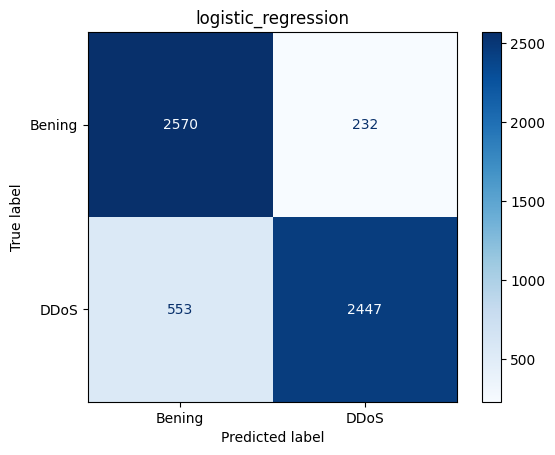


=== Test na zbiorze CICIDS2017 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.64      0.85      0.73     97718
           1       0.85      0.64      0.73    128027

    accuracy                           0.73    225745
   macro avg       0.74      0.74      0.73    225745
weighted avg       0.76      0.73      0.73    225745



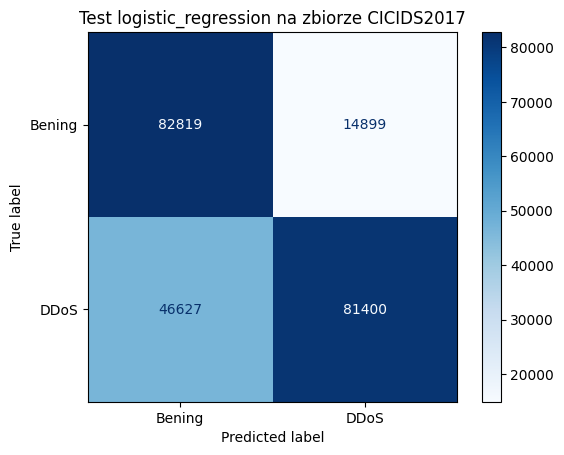


=== Analiza błędów: CICDDoS2019 → CICIDS2017 (logistic_regression) ===

🔍 False Positives (FP):
                 count          mean           std  min      25%       50%  \
Fwd IAT Total  14899.0  1.638932e+06  8.479894e+06  0.0     46.0  190081.0   
Flow IAT Max   14899.0  1.348530e+06  5.926040e+06  1.0  29987.0  122043.0   
Idle Max       14899.0  1.044640e+06  5.958958e+06  0.0      0.0       0.0   
Bwd IAT Total  14899.0  6.167625e+05  5.177955e+06  0.0      3.0     113.0   
Bwd IAT Std    14899.0  2.773868e+05  3.073769e+06  0.0      0.0       0.0   

                        75%          max  
Fwd IAT Total  766225.50000  120000000.0  
Flow IAT Max   693483.00000  120000000.0  
Idle Max            0.00000  120000000.0  
Bwd IAT Total  118674.00000  120000000.0  
Bwd IAT Std     23849.49689   76700000.0  

🔍 False Negatives (FN):
                 count          mean           std  min        25%        50%  \
Fwd IAT Total  46627.0  6.236928e+06  4.293961e+06  0.0  3260948.0  60

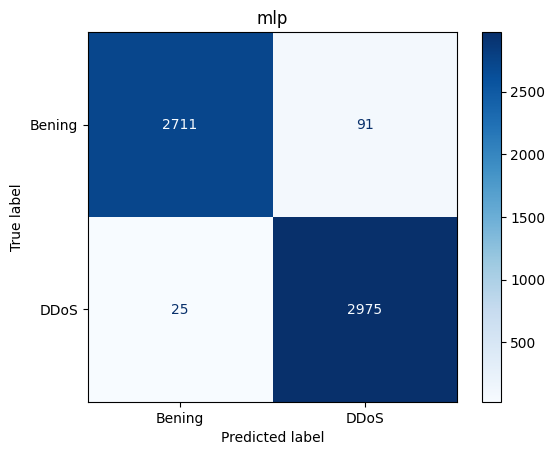


=== Test na zbiorze CICIDS2017 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.44      0.88      0.59     97718
           1       0.64      0.16      0.26    128027

    accuracy                           0.47    225745
   macro avg       0.54      0.52      0.42    225745
weighted avg       0.55      0.47      0.40    225745



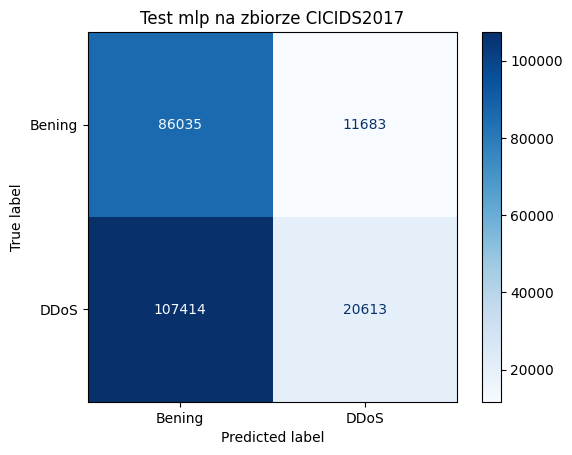


=== Analiza błędów: CICDDoS2019 → CICIDS2017 (mlp) ===

🔍 False Positives (FP):
                 count           mean           std  min   25%    50%  \
Fwd IAT Total  11683.0  965589.357870  8.738256e+06  0.0  48.0  440.0   
Bwd IAT Total  11683.0  537632.022939  6.115757e+06  0.0   0.0    0.0   
Flow IAT Max   11683.0  276716.771634  2.275922e+06 -1.0  69.0  649.0   
Idle Max       11683.0  170782.032269  1.672491e+06  0.0   0.0    0.0   
Bwd IAT Std    11683.0   19546.266157  5.399260e+05  0.0   0.0    0.0   

                   75%          max  
Fwd IAT Total  53961.5  120000000.0  
Bwd IAT Total      4.0  110000000.0  
Flow IAT Max   35144.0  107000000.0  
Idle Max           0.0   58900000.0  
Bwd IAT Std        0.0   41700000.0  

🔍 False Negatives (FN):
                  count          mean           std      min         25%  \
Fwd IAT Total  107414.0  1.967796e+07  3.282935e+07      0.0     5514.25   
Flow IAT Max   107414.0  1.886182e+07  3.037675e+07  86070.0  1163260.75   

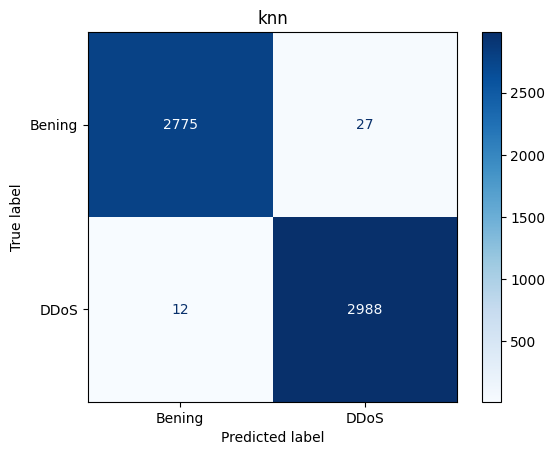


=== Test na zbiorze CICIDS2017 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.69      0.87      0.77     97718
           1       0.88      0.70      0.78    128027

    accuracy                           0.77    225745
   macro avg       0.78      0.79      0.77    225745
weighted avg       0.80      0.77      0.78    225745



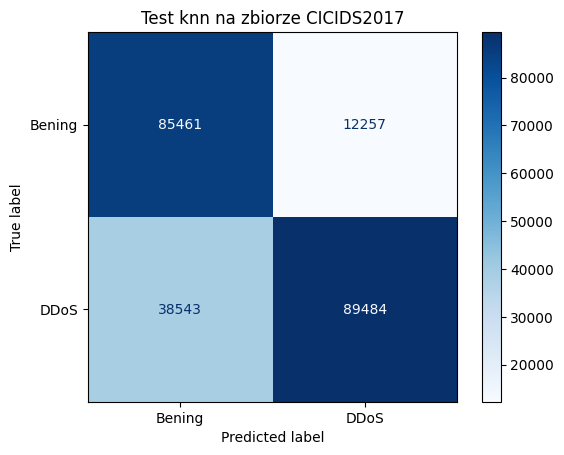


=== Analiza błędów: CICDDoS2019 → CICIDS2017 (knn) ===

🔍 False Positives (FP):
                 count           mean           std  min    25%      50%  \
Fwd IAT Total  12257.0  896088.123358  6.023394e+06  0.0   49.0  68681.0   
Flow IAT Max   12257.0  660240.352452  2.257659e+06  0.0  190.0  45961.0   
Bwd IAT Total  12257.0  162187.334176  2.661353e+06  0.0    0.0      4.0   
Idle Max       12257.0  118838.462674  1.450753e+06  0.0    0.0      0.0   
Bwd IAT Std    12257.0   35186.932065  9.882391e+05  0.0    0.0      0.0   

                    75%          max  
Fwd IAT Total  703533.0  120000000.0  
Flow IAT Max   656015.0  109000000.0  
Bwd IAT Total     132.0  109000000.0  
Idle Max            0.0   42800000.0  
Bwd IAT Std         0.0   63000000.0  

🔍 False Negatives (FN):
                 count          mean           std  min         25%  \
Fwd IAT Total  38543.0  5.070265e+07  3.852940e+07  0.0  10000000.0   
Flow IAT Max   38543.0  4.744524e+07  3.582356e+07  0.0  1000

In [ ]:
for model_name in models_to_test:
    print(f"\n================= TEST: {model_name.upper()} (2019 → 2017) =================")
    run_full_experiment(df_2019, df_2017, stable_2017, label_train='CICDDoS2019', label_test='CICIDS2017', model_type=model_name)


================= TEST: RANDOM_FOREST (2017 → 2019) =================

=== Model: RANDOM_FOREST | Trening na CICIDS2017 (90%), walidacja na CICIDS2017 (10%) ===
Wyniki walidacji:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9772
           1       1.00      1.00      1.00     12803

    accuracy                           1.00     22575
   macro avg       1.00      0.99      0.99     22575
weighted avg       1.00      1.00      1.00     22575



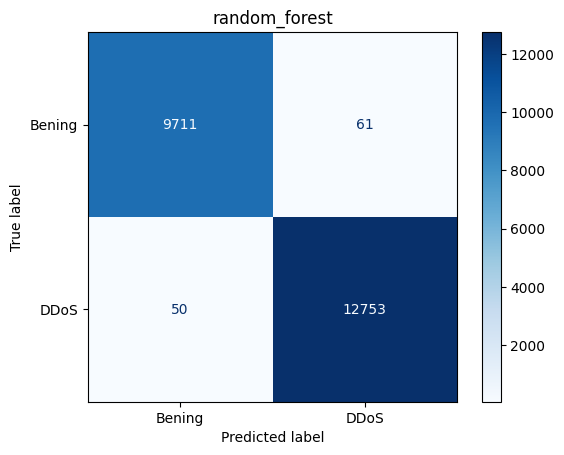


=== Test na zbiorze CICDDoS2019 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.48      0.98      0.65     28017
           1       0.57      0.02      0.04     30000

    accuracy                           0.49     58017
   macro avg       0.53      0.50      0.35     58017
weighted avg       0.53      0.49      0.34     58017



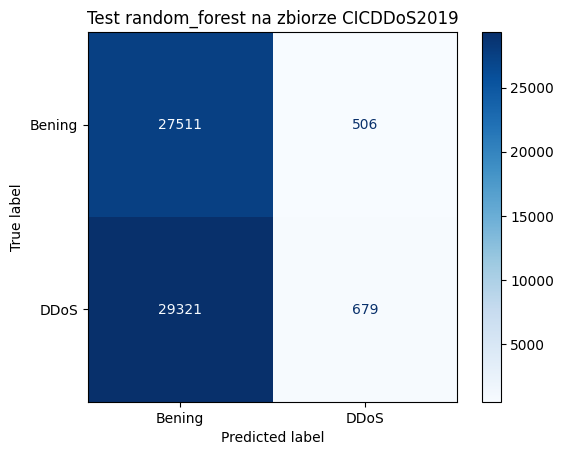


=== Analiza błędów: CICIDS2017 → CICDDoS2019 (random_forest) ===

🔍 False Positives (FP):
               count          mean           std     min        25%  \
Flow Duration  506.0  1.224799e+07  2.259388e+07  1002.0  284740.25   
Fwd IAT Min    506.0  9.385679e+04  7.490483e+05     0.0       1.00   
Flow IAT Min   506.0  9.385647e+04  7.490484e+05     0.0       1.00   
Bwd IAT Mean   506.0  3.711613e+04  8.150466e+04     0.0       0.00   
Bwd Packets/s  506.0  1.337529e+01  6.151897e+01     0.0       0.00   

                     50%           75%           max  
Flow Duration  1582094.0  9.015672e+06  1.016531e+08  
Fwd IAT Min          1.0  2.000000e+00  1.049346e+07  
Flow IAT Min         1.0  2.000000e+00  1.049346e+07  
Bwd IAT Mean         0.0  4.585950e+04  5.382923e+05  
Bwd Packets/s        0.0  9.666093e+00  1.220107e+03  

🔍 False Negatives (FN):
                 count           mean           std  min  25%  50%   75%  \
Flow Duration  29321.0  966642.279527  9.826163e+06

/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:16:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Wyniki walidacji:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      9772
           1       1.00      1.00      1.00     12803

    accuracy                           1.00     22575
   macro avg       1.00      1.00      1.00     22575
weighted avg       1.00      1.00      1.00     22575



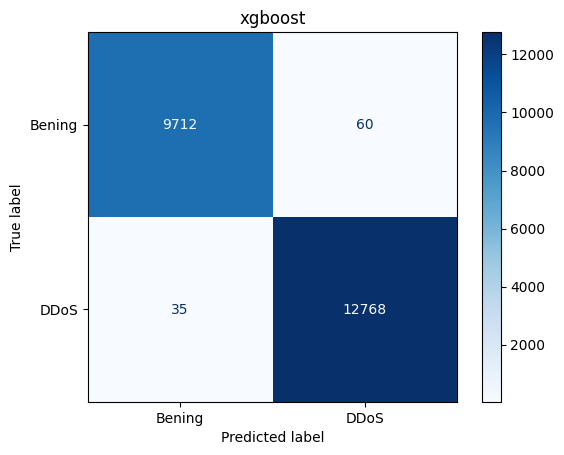


=== Test na zbiorze CICDDoS2019 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.49      0.98      0.65     28017
           1       0.65      0.03      0.06     30000

    accuracy                           0.49     58017
   macro avg       0.57      0.51      0.36     58017
weighted avg       0.57      0.49      0.35     58017



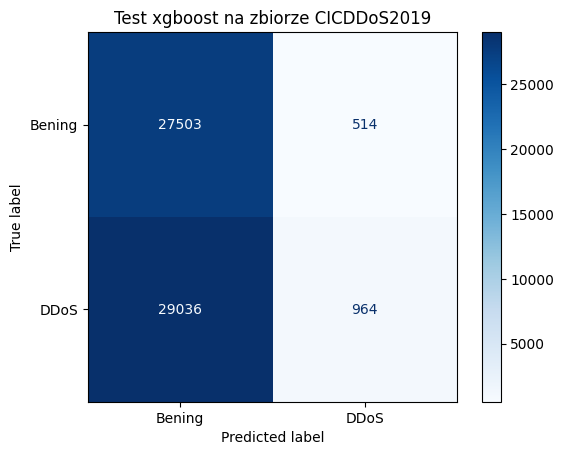


=== Analiza błędów: CICIDS2017 → CICDDoS2019 (xgboost) ===

🔍 False Positives (FP):
               count          mean           std     min        25%  \
Flow Duration  514.0  1.145270e+07  2.329270e+07  8924.0  276819.25   
Fwd IAT Min    514.0  8.020539e+04  7.273612e+05     0.0       1.00   
Flow IAT Min   514.0  8.020507e+04  7.273613e+05     0.0       1.00   
Bwd IAT Mean   514.0  3.615009e+04  7.892970e+04     0.0       0.00   
Bwd Packets/s  514.0  1.405453e+01  3.458037e+01     0.0       0.00   

                     50%           75%           max  
Flow Duration  1072755.0  9.015018e+06  1.199919e+08  
Fwd IAT Min          1.0  2.000000e+00  1.049346e+07  
Flow IAT Min         1.0  2.000000e+00  1.049346e+07  
Bwd IAT Mean         0.0  4.583038e+04  5.382923e+05  
Bwd Packets/s        0.0  1.348187e+01  2.403702e+02  

🔍 False Negatives (FN):
                 count           mean           std  min  25%  50%   75%  \
Flow Duration  29036.0  794669.026140  9.021389e+06  0.0 

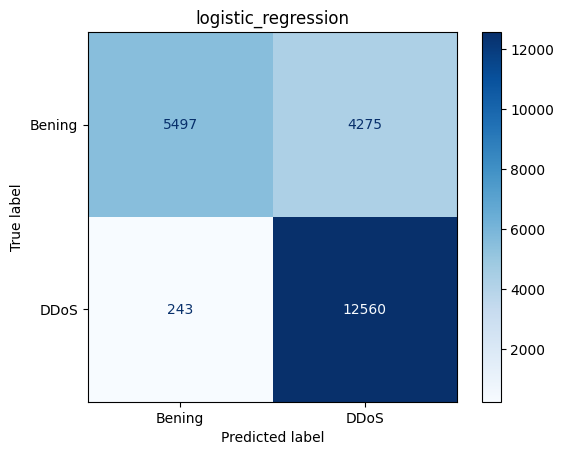


=== Test na zbiorze CICDDoS2019 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.92      0.21      0.34     28017
           1       0.57      0.98      0.72     30000

    accuracy                           0.61     58017
   macro avg       0.74      0.60      0.53     58017
weighted avg       0.74      0.61      0.54     58017



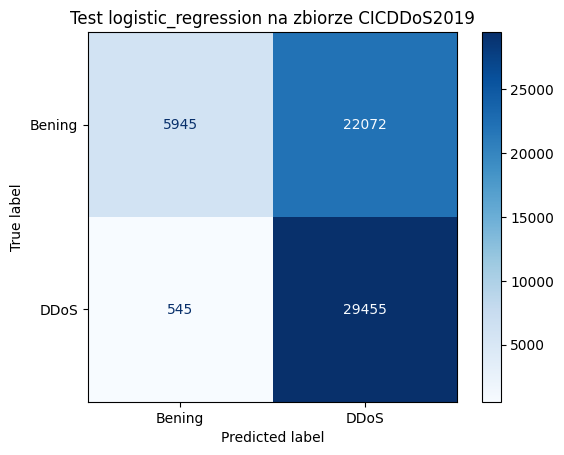


=== Analiza błędów: CICIDS2017 → CICDDoS2019 (logistic_regression) ===

🔍 False Positives (FP):
                 count          mean           std  min      25%  \
Flow Duration  22072.0  4.318650e+06  1.972671e+07  0.0  20497.0   
Bwd IAT Mean   22072.0  3.414631e+04  2.205922e+05  0.0      0.0   
Flow IAT Min   22072.0  2.287553e+03  1.169567e+04  0.0      1.0   
Fwd IAT Min    22072.0  1.185650e+03  4.688470e+04  0.0      1.0   
Bwd Packets/s  22072.0  5.020623e+01  6.641144e+01  0.0      0.0   

                        50%           75%           max  
Flow Duration  20875.000000  55038.000000  1.199959e+08  
Bwd IAT Mean       2.000000      3.000000  2.613634e+06  
Flow IAT Min       2.000000      3.000000  5.921170e+05  
Fwd IAT Min        2.000000      3.000000  5.158476e+06  
Bwd Packets/s     42.041979     96.015362  1.865672e+03  

🔍 False Negatives (FN):
               count          mean           std        min           25%  \
Flow Duration  545.0  1.034096e+07  3.087813

/home/mati/GeneralizationCapabilityOfML/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Wyniki walidacji:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      9772
           1       0.90      0.98      0.94     12803

    accuracy                           0.92     22575
   macro avg       0.93      0.92      0.92     22575
weighted avg       0.93      0.92      0.92     22575



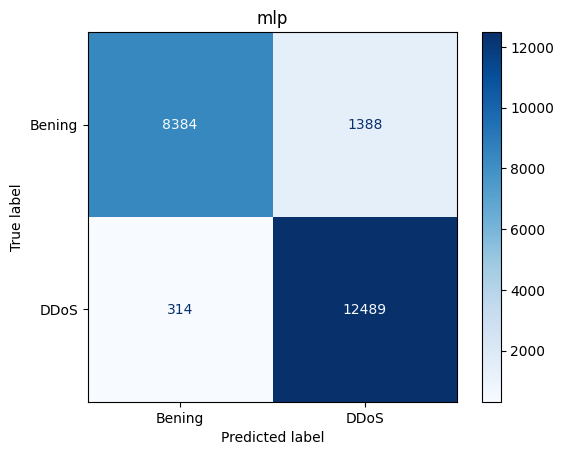


=== Test na zbiorze CICDDoS2019 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.44      0.83      0.57     28017
           1       0.06      0.01      0.02     30000

    accuracy                           0.41     58017
   macro avg       0.25      0.42      0.30     58017
weighted avg       0.24      0.41      0.29     58017



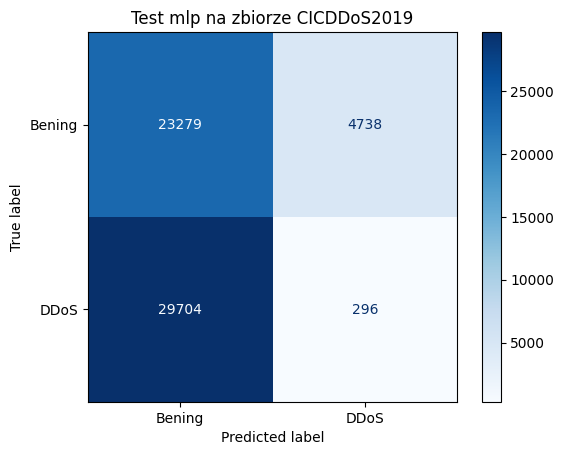


=== Analiza błędów: CICIDS2017 → CICDDoS2019 (mlp) ===

🔍 False Positives (FP):
                count          mean           std     min           25%  \
Flow Duration  4738.0  2.698054e+06  1.098065e+07  2787.0  20612.000000   
Bwd IAT Mean   4738.0  1.585352e+04  5.358264e+04     0.0      2.000000   
Fwd IAT Min    4738.0  1.178455e+04  2.699687e+05     0.0      1.000000   
Flow IAT Min   4738.0  1.178412e+04  2.699687e+05     0.0      1.000000   
Bwd Packets/s  4738.0  7.245916e+01  6.593286e+01     0.0     10.853973   

                        50%           75%           max  
Flow Duration  86274.000000  1.054458e+06  1.047319e+08  
Bwd IAT Mean       3.000000  9.169438e+03  7.042485e+05  
Fwd IAT Min        2.000000  3.000000e+00  1.049346e+07  
Flow IAT Min       1.000000  2.000000e+00  1.049346e+07  
Bwd Packets/s     96.918007  9.719944e+01  7.176175e+02  

🔍 False Negatives (FN):
                 count           mean           std  min  25%  50%   75%  \
Flow Duration  2970

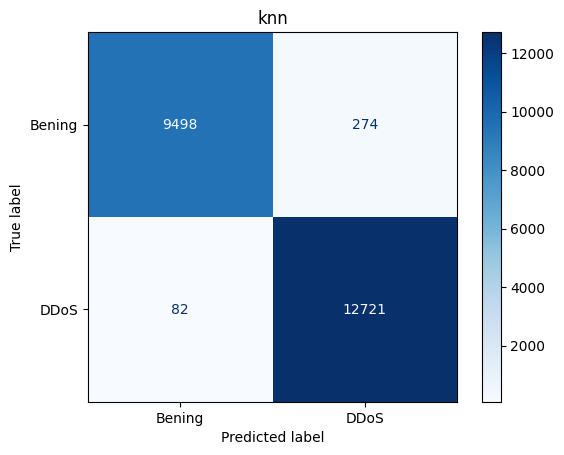


=== Test na zbiorze CICDDoS2019 ===
Wyniki testu cross-dataset:
              precision    recall  f1-score   support

           0       0.48      0.96      0.64     28017
           1       0.46      0.03      0.05     30000

    accuracy                           0.48     58017
   macro avg       0.47      0.50      0.35     58017
weighted avg       0.47      0.48      0.34     58017



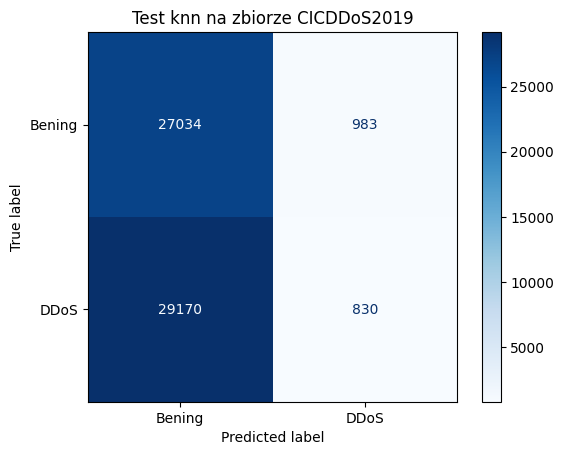


=== Analiza błędów: CICIDS2017 → CICDDoS2019 (knn) ===

🔍 False Positives (FP):
               count          mean           std   min       25%  \
Flow Duration  983.0  1.054005e+07  2.206388e+07  43.0  917777.0   
Bwd IAT Mean   983.0  4.309541e+04  1.174068e+05   0.0       0.0   
Fwd IAT Min    983.0  2.136294e+04  4.129508e+05   0.0       1.0   
Flow IAT Min   983.0  2.136252e+04  4.129508e+05   0.0       1.0   
Bwd Packets/s  983.0  6.288852e+01  1.484520e+03   0.0       0.0   

                        50%           75%           max  
Flow Duration  5.289164e+06  6.848274e+06  1.048807e+08  
Bwd IAT Mean   2.000000e+00  8.307595e+03  1.055362e+06  
Fwd IAT Min    2.000000e+00  2.000000e+00  1.049346e+07  
Flow IAT Min   1.000000e+00  2.000000e+00  1.049346e+07  
Bwd Packets/s  3.770898e-01  2.431457e+00  4.651163e+04  

🔍 False Negatives (FN):
                 count           mean           std  min  25%  50%   75%  \
Flow Duration  29170.0  519465.395441  7.375663e+06  0.0  1.0

In [ ]:
for model_name in models_to_test:
    print(f"\n================= TEST: {model_name.upper()} (2017 → 2019) =================")
    run_full_experiment(df_2017, df_2019, stable_2019, label_train='CICIDS2017', label_test='CICDDoS2019', model_type=model_name)